# Encoder optimization

**Goal:** Get a jist for what a good size for the encoder is.

**Plan:** With the rings optimization, start with **one** ring, and predict the semantic segmentation map or position / radius of the ring.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Lukas's slot attention code
import os
os.sys.path.append('code')

from model import build_grid,SlotAttentionEncoder
from data import gen_events

%load_ext autoreload
%autoreload 2

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device='cpu'

## 1. Load in the data

In [3]:
nPixels = 32

xlow = -0.5
xhigh = 0.5
binWidth = (xhigh-xlow)/(nPixels+1)

stdlow = 0.01
stdhigh = 0.05

bins = np.arange(xlow,xhigh,binWidth)

nBins = len(bins)-1

In [4]:
bs = 128

centers,img_Es = gen_events(bins, N_events=bs, isRing=True, blurImage=False,
                            xlow=xlow,xhigh=xhigh,stdlow=stdlow,stdhigh=stdhigh)

In [5]:
img_Es.shape

(128, 32, 32, 1)

In [6]:
centers.shape

(128, 1, 4)

These centers that get returned correspond to
- (x,y) position
- variance of the cluster
- blur of the cluster (always 0)

In [7]:
centers[:,0,-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

(array([ 9., 13., 16.,  9., 12., 16., 15., 13., 14., 11.]),
 array([0.01021869, 0.01419062, 0.01816255, 0.02213449, 0.02610642,
        0.03007835, 0.03405029, 0.03802222, 0.04199415, 0.04596609,
        0.04993802]),
 <BarContainer object of 10 artists>)

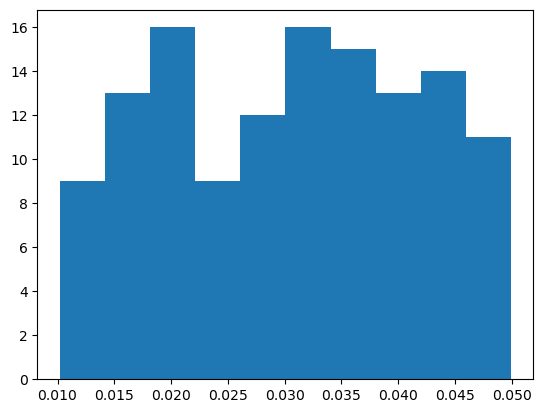

In [8]:
plt.hist(centers[:,0,2])

## 2. Predict a semantic segmentation mask

In [9]:
mask = img_Es > 0 

- Set up a simple CNN architecture to get the output pixels.
- For now, just consider one input dimension, even though LH's code allows for more output dimensions.

**Q: Should I log the energies?**

In [10]:
X = torch.FloatTensor(img_Es).to(device).permute(0,3,1,2)

In [11]:
X.shape

torch.Size([128, 1, 32, 32])

In [12]:
hidden_dim = 32

cnn = torch.nn.Sequential(
            torch.nn.Conv2d(1, hidden_dim, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_dim, hidden_dim, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_dim, 1, 5, padding=2),
            torch.nn.Sigmoid() 
    ).to(device)

In [13]:
out = cnn(X).detach().cpu().numpy()

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [15]:
mask.shape

(128, 32, 32, 1)

In [16]:
def plotit(losses, imgs):
    
    fig, axs = plt.subplots(1,4,figsize=(10,3))

    axs[0].plot(losses)
    
    for i, (ax,img,title) in enumerate(zip(axs[1:],imgs,
                                        ['Input image','Target mask','Predicted mask'])):

        im = ax.imshow(img.squeeze(),cmap='Blues')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)

        ax.axis('off')
        
    plt.show()

### Training loop

In [17]:
centers.shape

(128, 1, 4)

In [18]:
def make_batch(bs):
    
    # Load in data from Florian's fct
    centers,img_Es = gen_events(bins, N_events=bs)
    
    # Convert to a torch tensor
    X = torch.FloatTensor(img_Es).to(device).permute(0,3,1,2)
    Y = torch.FloatTensor(centers[:,0,:3]).to(device)
    
    # Get the semantic segmentation mask
    mask = X > 0
    
    return X, Y, mask

In [19]:
bs=32

# Learning rate schedule config
learning_rate = 3e-4
warmup_steps = 5_000
decay_steps=50_000
decay_rate = 0.5

In [20]:
def train(model, Ntrain = 5000):
    
    learning_rate = 3e-4
    opt = torch.optim.Adam(model.parameters(), learning_rate)
    model.train()
    losses = []
    
        
    for i in range(Ntrain):
    
#         if i < warmup_steps:
#             learning_rate *= (i / warmup_steps)
        learning_rate *= np.power(decay_rate, i / decay_steps)
        
        opt.param_groups[0]['lr'] = learning_rate

        X, Y, mask = make_batch(bs)
        pred = model(X)
        
        loss = torch.nn.functional.binary_cross_entropy(pred,mask)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(float(loss))
        if i % 250 == 0:
            print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            
            iEvt = 0
            imgs = [X.detach().cpu().numpy()[0].squeeze(),
                    mask.detach().cpu().numpy()[0].squeeze(),
                    pred.detach().cpu().numpy()[0].squeeze()]
            plotit(losses,imgs)

    model.eval()
    return model,losses

iter 0 , loss 0.6993669 , lr 0.0003


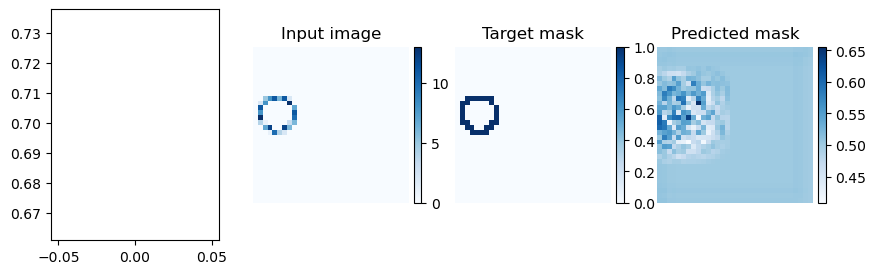

iter 250 , loss 0.0093519585 , lr 0.00019418913733795133


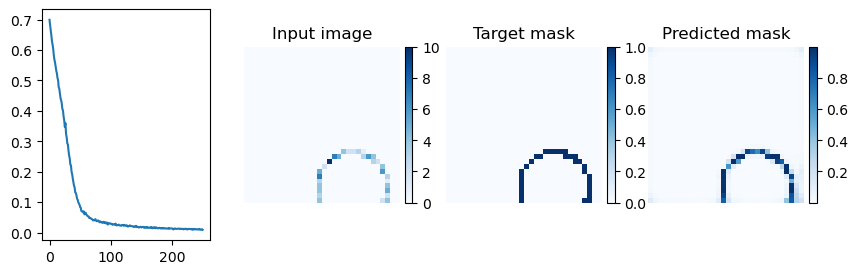

iter 500 , loss 0.005565906 , lr 5.2849528317825775e-05


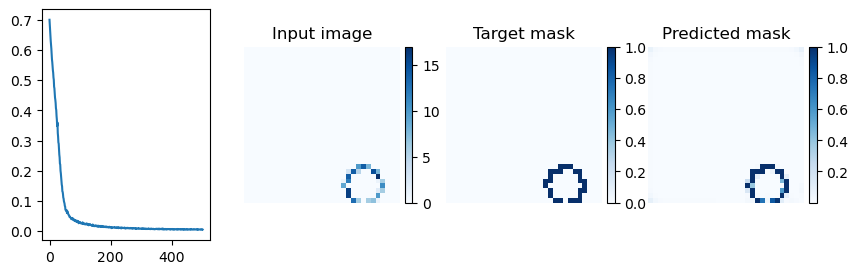

iter 750 , loss 0.005355525 , lr 6.04741543628372e-06


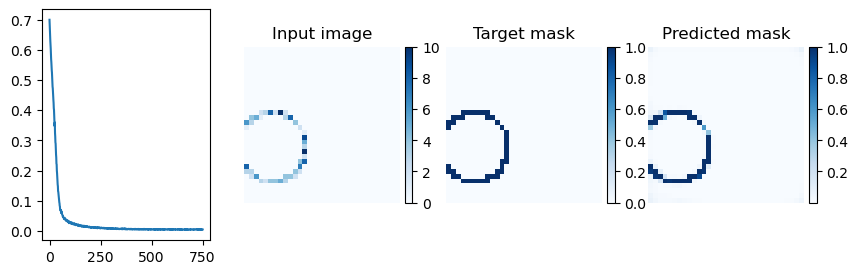

iter 1000 , loss 0.004606288 , lr 2.909450670225699e-07


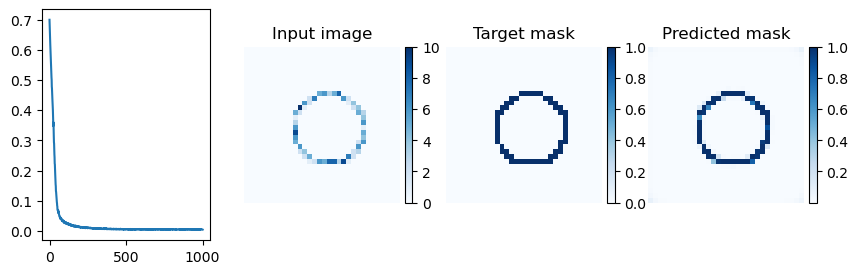

iter 1250 , loss 0.0047531864 , lr 5.88524703935888e-09


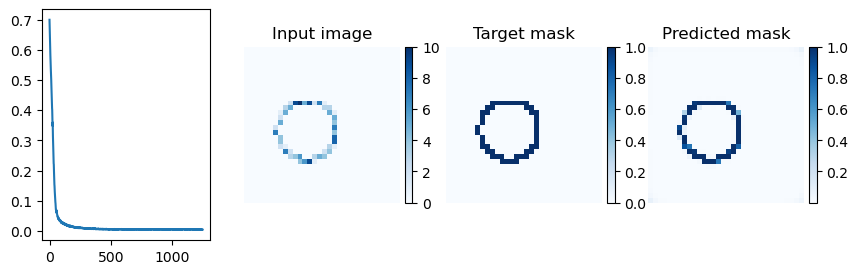

iter 1500 , loss 0.0053030057 , lr 5.005309101087569e-11


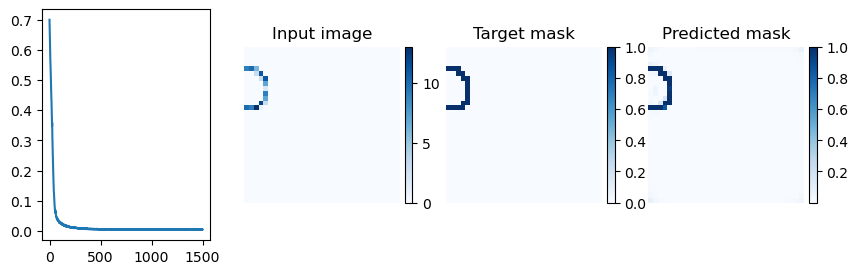

iter 1750 , loss 0.004903936 , lr 1.7898210545073331e-13


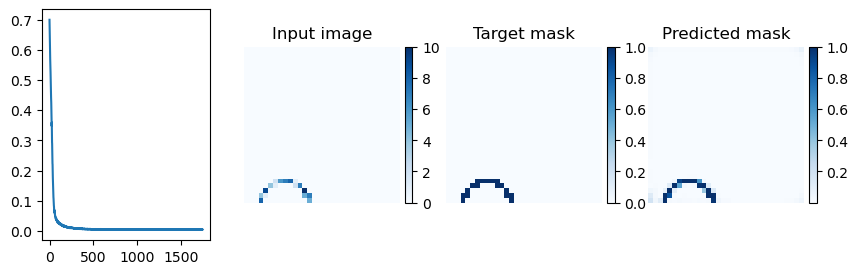

In [21]:
hidden_dim = 32

cnn = torch.nn.Sequential(
            torch.nn.Conv2d(1, hidden_dim, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_dim, hidden_dim, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_dim, 1, 5, padding=2),
            torch.nn.Sigmoid() 
    ).to(device)

cnn, losses = train(cnn,2000)

### Lesson:
- This model architecture is good to go, but the warm-up learning schedule was at least not optimal for at least the section where the CNN needed to learn

**To watch out for:** Optimizer schedule!!

## 3. Predict a circle radius

**Next step:** Predict the center locations and the radii.

**Plan:** I'll start just doing a _raw_ prediction, and then I'll try adding the final positional information to see if that helps too.


In [22]:
class regressionCNN(torch.nn.Module):
    '''
    CNN to regress the circle properties:
    - position (x,y)
    - radiu
    '''
    def __init__(self, hidden_dim=hidden_dim, mlp_dim=64):
        '''
        '''
        super().__init__()
        
        self.cnn = torch.nn.Sequential(
                    torch.nn.Conv2d(1, hidden_dim, 5, padding=2),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(hidden_dim, hidden_dim, 5, padding=2),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(hidden_dim, 1, 5, padding=2),
        )
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(nPixels*nPixels,mlp_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(mlp_dim,3)
        )

    def forward(self,X):
        Y = self.cnn(X)
        Y = torch.flatten(Y,1)
        Y = self.mlp(Y)
        
        # As per Florian's suggestion... predict \log sigma^2
        Y[:,-1] = torch.exp(Y[:,-1])
        
        return Y
        

New training loop to train the positions!!

In [23]:
from matplotlib.patches import Circle

In [24]:
def plotit_reg(losses, img, true_i, pred_i):
    '''
    Plot the evaluation of the _single ring_ 
    getting predicted on smth else.
    '''
    fig, [ax1, ax2] = plt.subplots(1,2,figsize=(9,4))
    
    # Plot the losses
    ax1.plot(losses)
    ax1.set_title('loss')
    
    # Show the reco and pred img
    im = ax2.imshow(img,'RdBu_r', extent=[xlow,xhigh]*2, origin='lower')
    
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.set_ylabel('Input image',rotation=270)
    
    for yi, color,label in zip([true_i, pred_i],['cyan','r'],['true','pred']):

        ax2.scatter(*yi[:2],label=label,marker='X',color=color)
        print(f'Circle at ({yi[0]:.2f},{yi[1]:.2f}) with variance {yi[2]:.3f}')
        circle = Circle(yi[:2],np.sqrt(yi[2]),fill=False,color=color)
        ax2.add_patch(circle)

    ax2.legend()
    ax2.set_xlim(xlow,xhigh)
    ax2.set_ylim(xlow,xhigh)
    
    plt.show()

In [25]:
bs = 64

In [26]:
def train_reg(model, Ntrain = 5000):
    
    learning_rate = 3e-4
    opt = torch.optim.Adam(model.parameters(), learning_rate)
    model.train()
    losses = []
            
    for i in range(Ntrain):
    
#         if i < warmup_steps:
#             learning_rate *= (i / warmup_steps)
#         learning_rate *= np.power(decay_rate, i / decay_steps)
        
        opt.param_groups[0]['lr'] = learning_rate

        X, Y, mask = make_batch(bs)
        pred = model(X)
            
        loss = torch.nn.functional.mse_loss(pred,Y)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(float(loss))
        if i % 250 == 0:
            print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            
            iEvt = 0
            args = [X[iEvt].detach().cpu().numpy().squeeze(),
                    Y[iEvt].detach().cpu().numpy(),
                    pred[iEvt].detach().cpu().numpy()]
            plotit_reg(losses,*args)
            
    model.eval()
    return model,losses

**Goal:** Sort out why the true _isn't_ matching the circle.

Should the NN predict $\log \sigma^2$ instead? This is what Flo is doing :)

iter 0 , loss 0.45397097 , lr 0.0003
Circle at (-0.27,-0.30) with variance 0.025
Circle at (0.07,0.05) with variance 1.126


iter 250 , loss 0.007113103 , lr 0.0003
Circle at (-0.03,0.26) with variance 0.039
Circle at (0.01,0.31) with variance 0.022


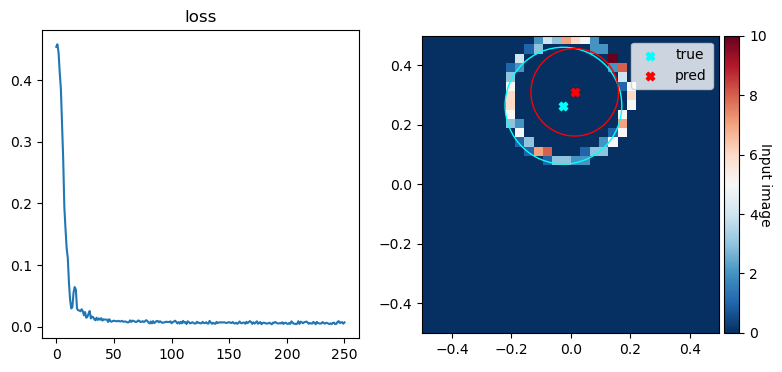

iter 500 , loss 0.0033595432 , lr 0.0003
Circle at (0.24,-0.04) with variance 0.028
Circle at (0.17,-0.00) with variance 0.024


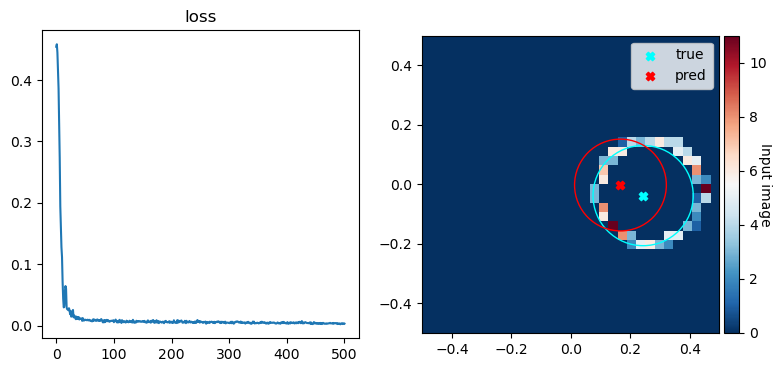

iter 750 , loss 0.0018467638 , lr 0.0003
Circle at (-0.26,-0.26) with variance 0.032
Circle at (-0.15,-0.20) with variance 0.021


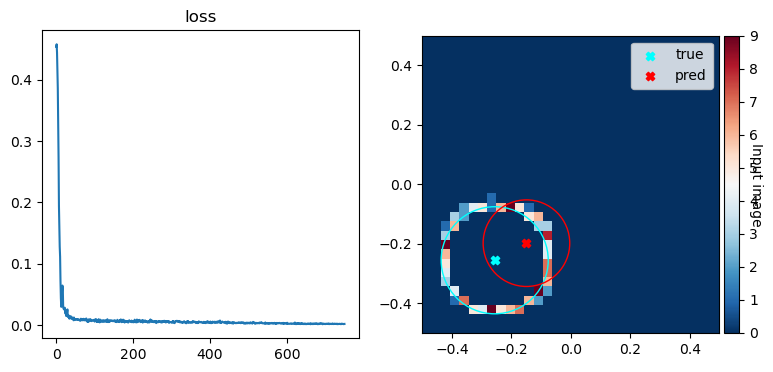

iter 1000 , loss 0.0014066793 , lr 0.0003
Circle at (-0.28,-0.47) with variance 0.038
Circle at (-0.24,-0.44) with variance 0.031


iter 1250 , loss 0.0010764343 , lr 0.0003
Circle at (-0.38,0.33) with variance 0.043
Circle at (-0.35,0.30) with variance 0.031


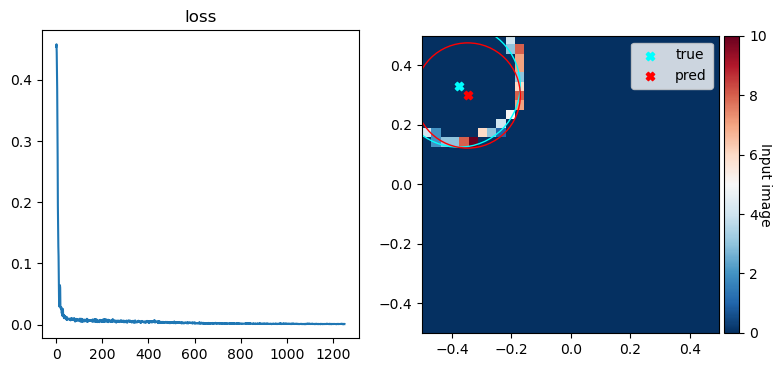

iter 1500 , loss 0.0007008845 , lr 0.0003
Circle at (-0.07,0.45) with variance 0.020
Circle at (-0.08,0.46) with variance 0.035


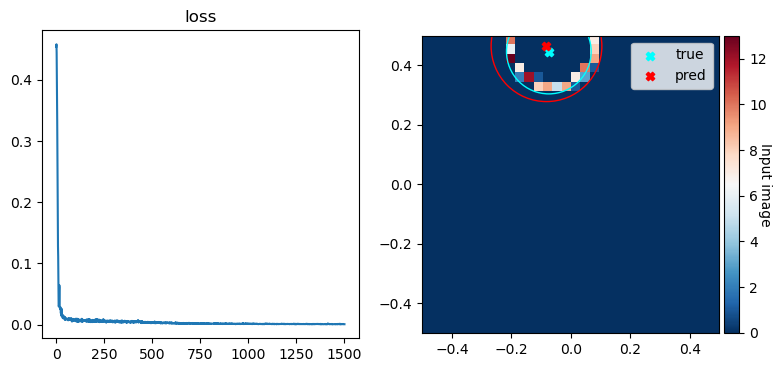

iter 1750 , loss 0.0007455507 , lr 0.0003
Circle at (-0.12,0.29) with variance 0.031
Circle at (-0.14,0.34) with variance 0.023


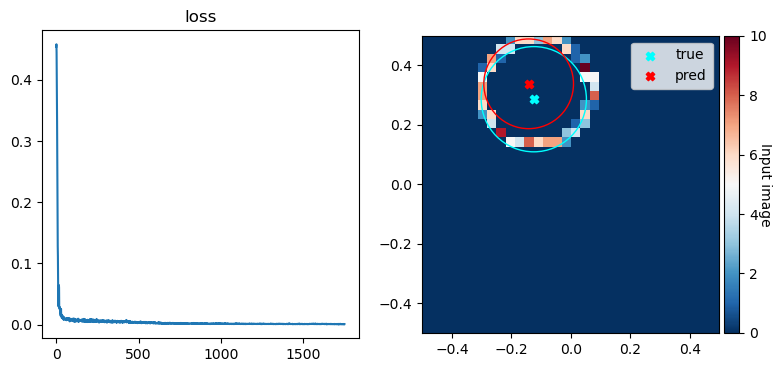

iter 2000 , loss 0.0008684527 , lr 0.0003
Circle at (-0.21,-0.39) with variance 0.026
Circle at (-0.20,-0.45) with variance 0.024


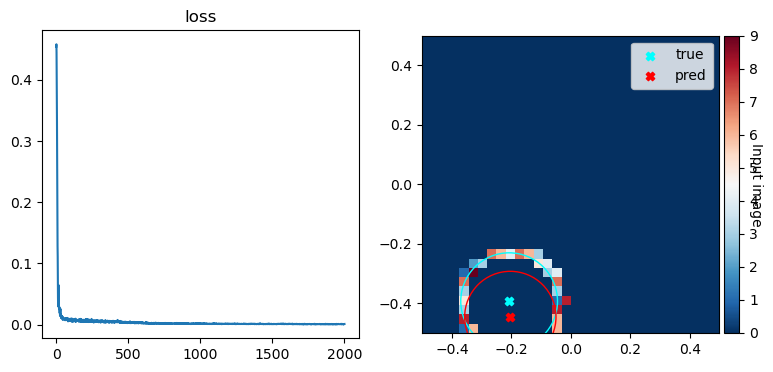

iter 2250 , loss 0.0005667912 , lr 0.0003
Circle at (0.13,0.20) with variance 0.011
Circle at (0.11,0.17) with variance 0.030


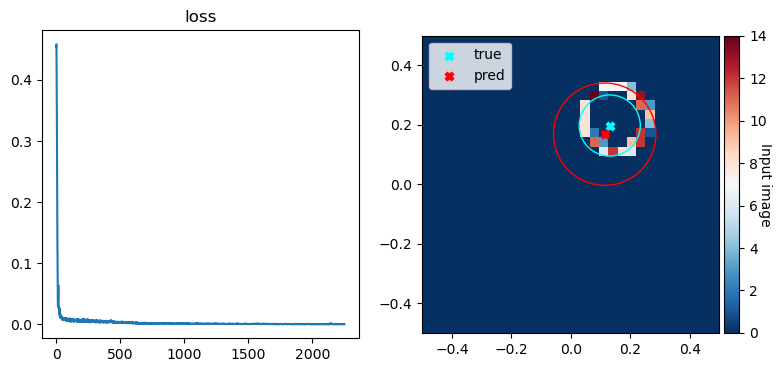

iter 2500 , loss 0.0005053105 , lr 0.0003
Circle at (0.26,-0.29) with variance 0.016
Circle at (0.28,-0.33) with variance 0.030


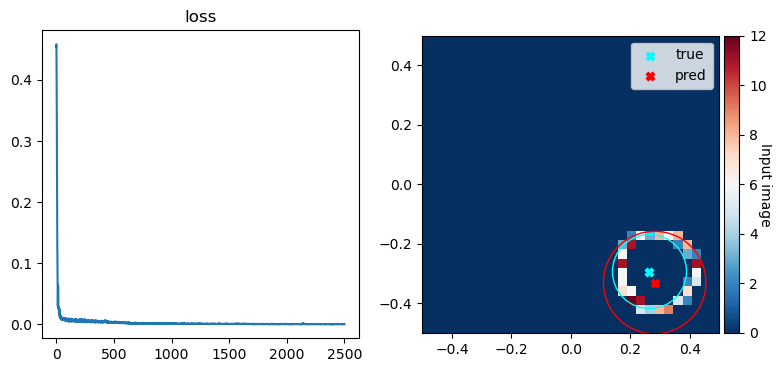

iter 2750 , loss 0.000508598 , lr 0.0003
Circle at (-0.22,0.24) with variance 0.020
Circle at (-0.24,0.23) with variance 0.032


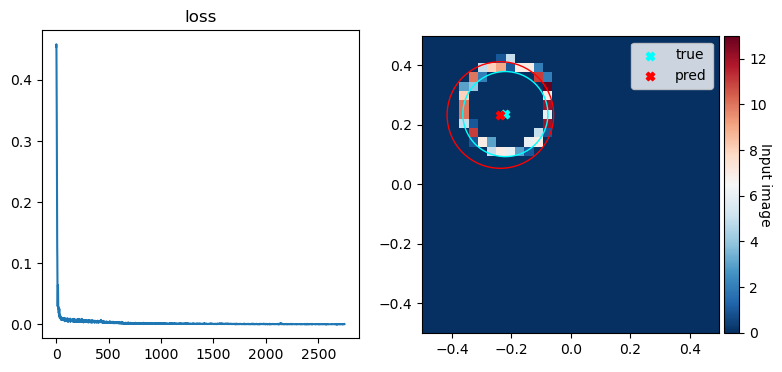

iter 3000 , loss 0.00034860324 , lr 0.0003
Circle at (-0.19,0.10) with variance 0.031
Circle at (-0.20,0.11) with variance 0.022


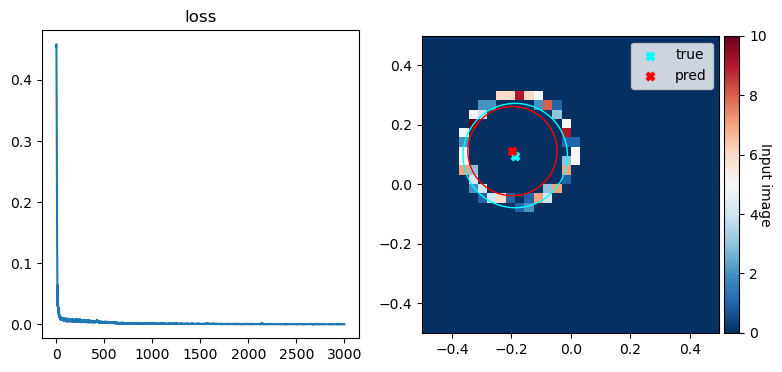

iter 3250 , loss 0.00042980636 , lr 0.0003
Circle at (-0.02,0.07) with variance 0.043
Circle at (-0.01,0.08) with variance 0.019


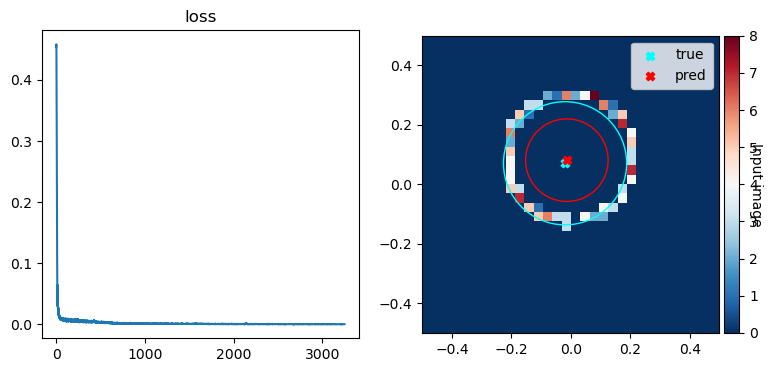

iter 3500 , loss 0.0003322122 , lr 0.0003
Circle at (0.39,-0.10) with variance 0.049
Circle at (0.40,-0.12) with variance 0.021


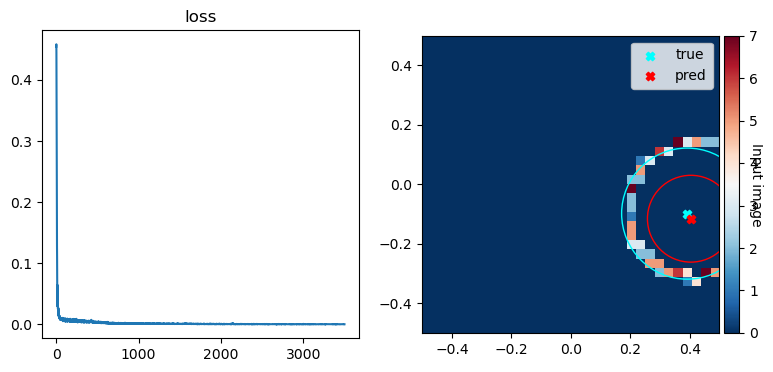

iter 3750 , loss 0.00030836603 , lr 0.0003
Circle at (-0.47,0.35) with variance 0.013
Circle at (-0.50,0.37) with variance 0.027


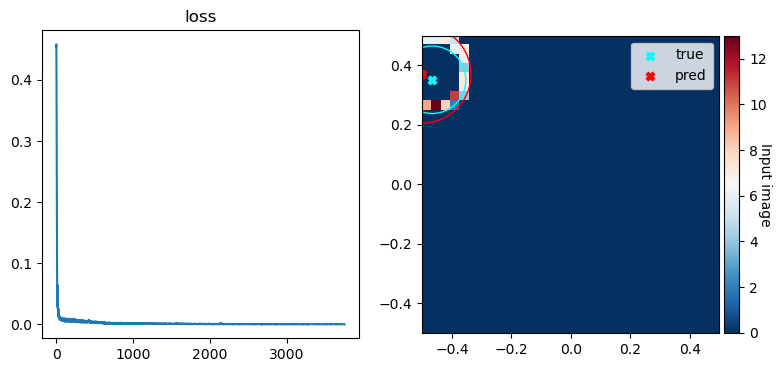

iter 4000 , loss 0.00037545385 , lr 0.0003
Circle at (-0.24,-0.13) with variance 0.042
Circle at (-0.24,-0.12) with variance 0.022


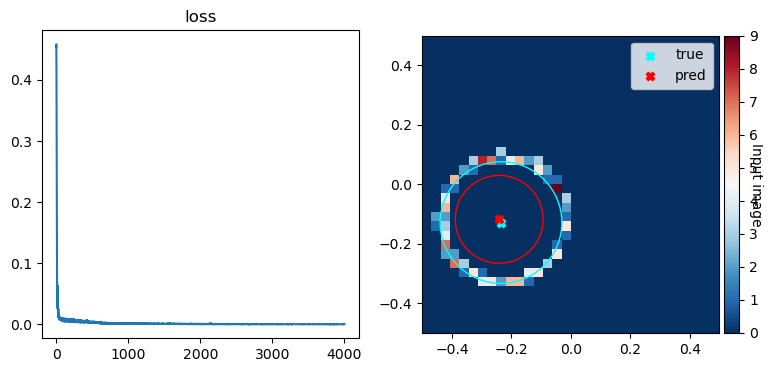

iter 4250 , loss 0.00030499746 , lr 0.0003
Circle at (0.20,0.03) with variance 0.025
Circle at (0.21,0.03) with variance 0.028


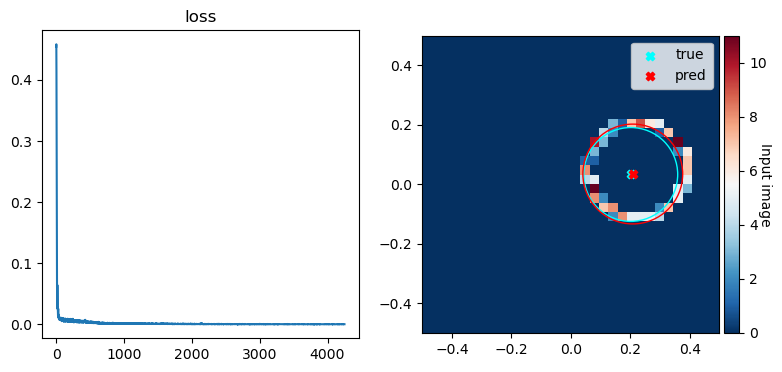

iter 4500 , loss 0.00021368999 , lr 0.0003
Circle at (-0.19,0.35) with variance 0.013
Circle at (-0.21,0.35) with variance 0.032


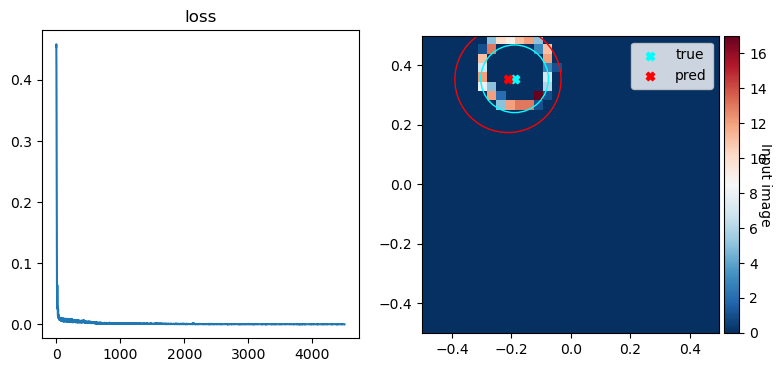

iter 4750 , loss 0.00034278864 , lr 0.0003
Circle at (0.35,-0.47) with variance 0.036
Circle at (0.35,-0.45) with variance 0.030


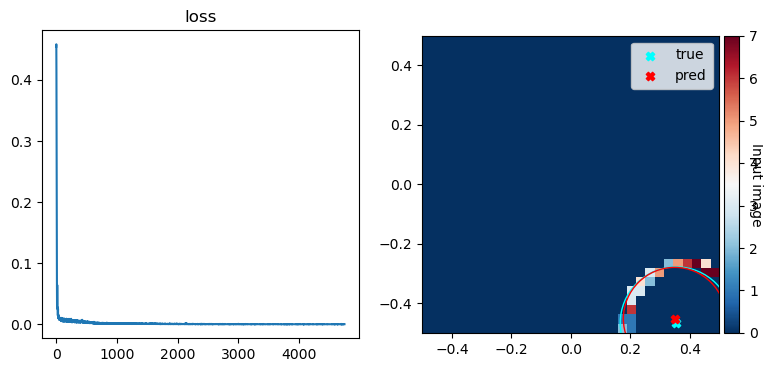

iter 5000 , loss 0.0003746322 , lr 0.0003
Circle at (0.49,-0.18) with variance 0.026
Circle at (0.50,-0.19) with variance 0.033


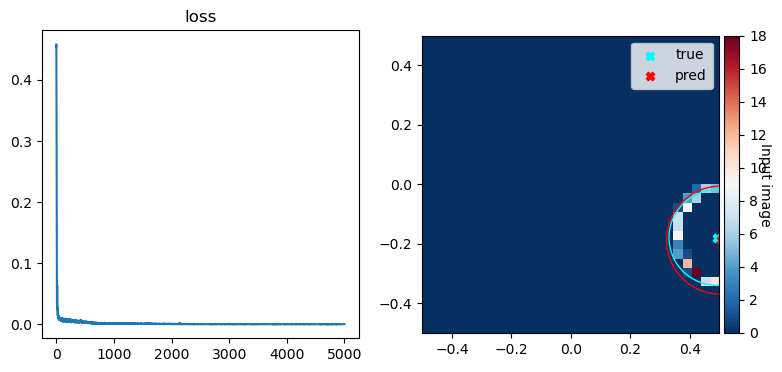

iter 5250 , loss 0.00036141597 , lr 0.0003
Circle at (-0.35,0.21) with variance 0.045
Circle at (-0.32,0.21) with variance 0.025


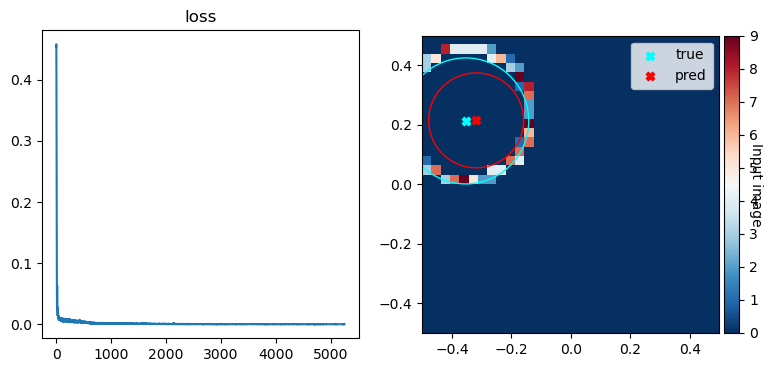

iter 5500 , loss 0.0002593196 , lr 0.0003
Circle at (-0.02,-0.25) with variance 0.020
Circle at (-0.01,-0.25) with variance 0.033


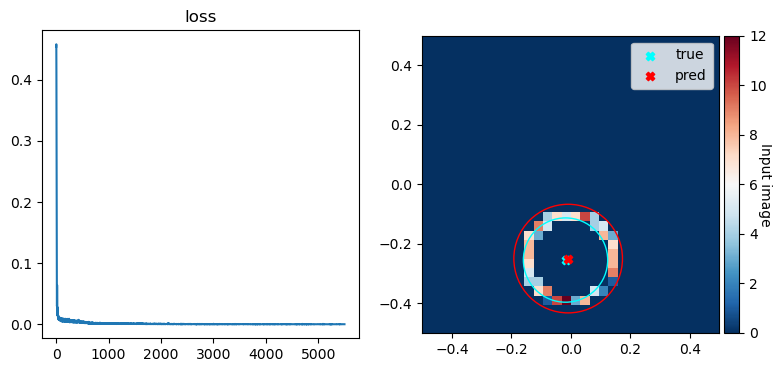

iter 5750 , loss 0.00020503483 , lr 0.0003
Circle at (0.06,-0.48) with variance 0.045
Circle at (0.08,-0.48) with variance 0.021


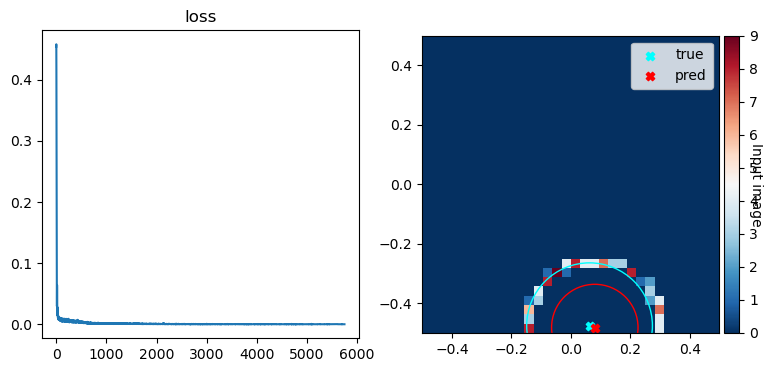

iter 6000 , loss 0.00024595077 , lr 0.0003
Circle at (-0.16,-0.20) with variance 0.021
Circle at (-0.17,-0.19) with variance 0.034


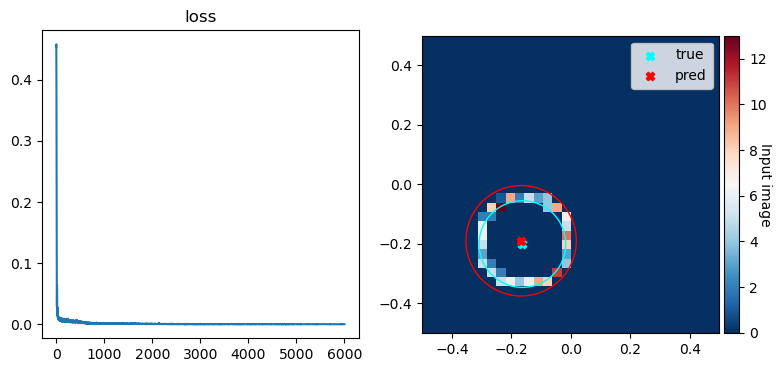

iter 6250 , loss 0.00018444192 , lr 0.0003
Circle at (-0.34,0.07) with variance 0.021
Circle at (-0.33,0.07) with variance 0.031


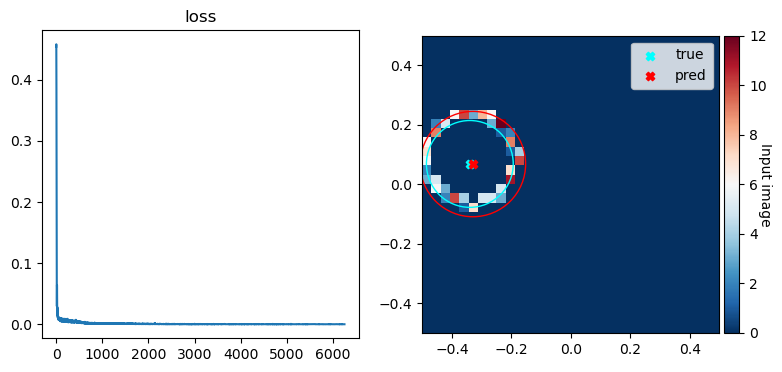

iter 6500 , loss 0.000209706 , lr 0.0003
Circle at (-0.32,-0.03) with variance 0.046
Circle at (-0.34,-0.01) with variance 0.018


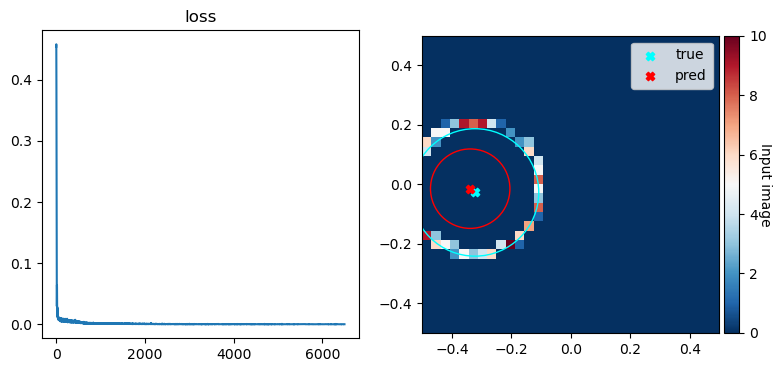

iter 6750 , loss 0.00016849954 , lr 0.0003
Circle at (-0.13,-0.31) with variance 0.021
Circle at (-0.13,-0.31) with variance 0.032


iter 7000 , loss 0.00015575669 , lr 0.0003
Circle at (0.29,0.15) with variance 0.029
Circle at (0.30,0.16) with variance 0.033


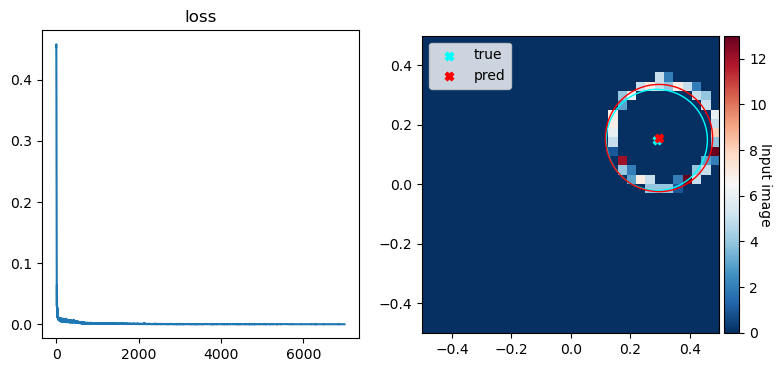

iter 7250 , loss 0.00015824813 , lr 0.0003
Circle at (-0.31,-0.11) with variance 0.025
Circle at (-0.32,-0.10) with variance 0.035


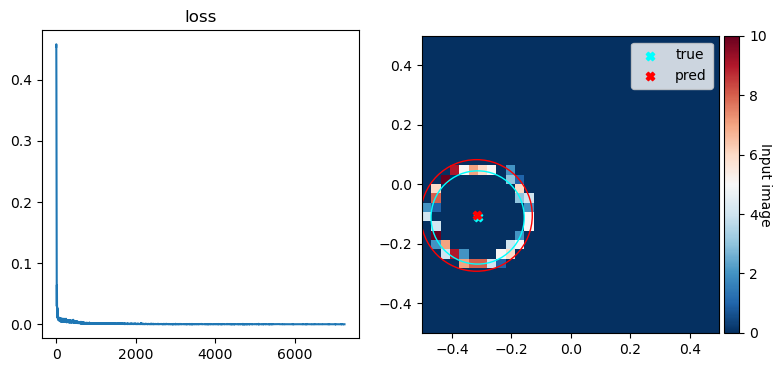

iter 7500 , loss 0.0001714098 , lr 0.0003
Circle at (0.37,-0.49) with variance 0.048
Circle at (0.37,-0.48) with variance 0.027


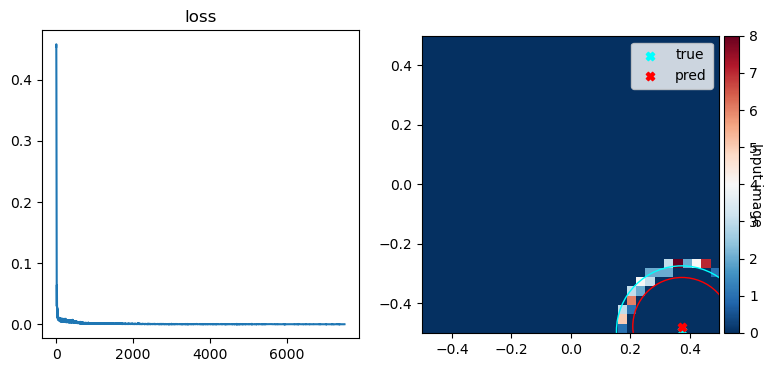

iter 7750 , loss 0.00015024096 , lr 0.0003
Circle at (0.43,-0.37) with variance 0.031
Circle at (0.43,-0.40) with variance 0.026


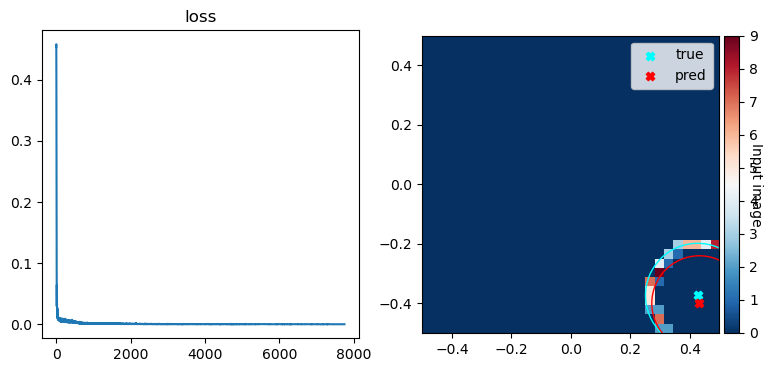

iter 8000 , loss 0.00013786952 , lr 0.0003
Circle at (-0.10,-0.01) with variance 0.011
Circle at (-0.09,-0.01) with variance 0.026


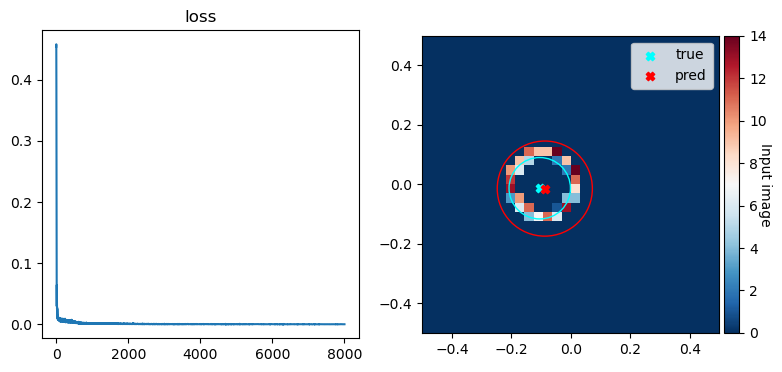

iter 8250 , loss 0.0001024759 , lr 0.0003
Circle at (0.38,-0.21) with variance 0.032
Circle at (0.38,-0.22) with variance 0.034


iter 8500 , loss 0.000119662596 , lr 0.0003
Circle at (-0.47,-0.01) with variance 0.035
Circle at (-0.48,-0.01) with variance 0.027


iter 8750 , loss 7.902332e-05 , lr 0.0003
Circle at (-0.40,-0.31) with variance 0.043
Circle at (-0.40,-0.31) with variance 0.032


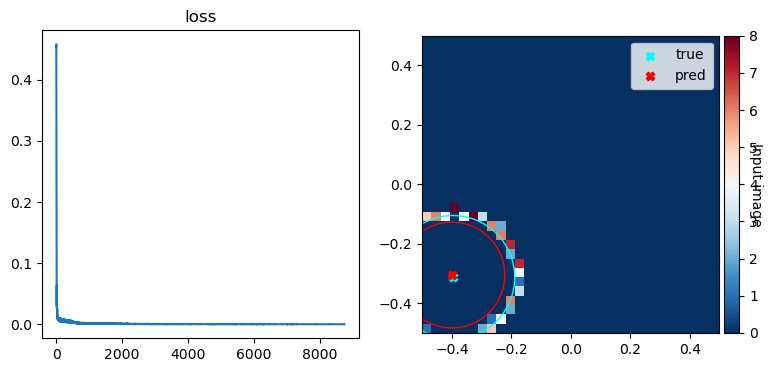

iter 9000 , loss 9.126096e-05 , lr 0.0003
Circle at (-0.08,-0.23) with variance 0.045
Circle at (-0.07,-0.24) with variance 0.043


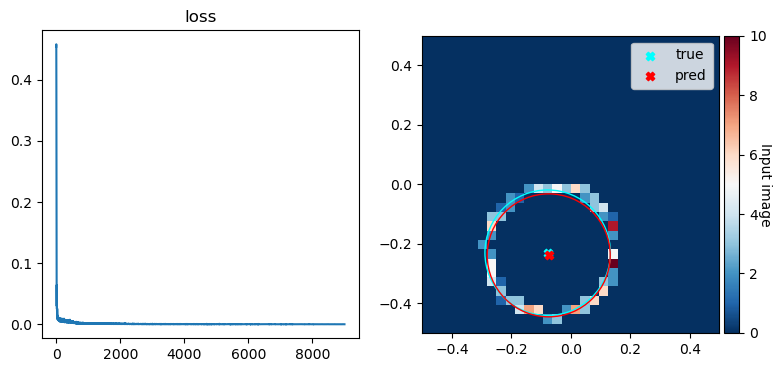

iter 9250 , loss 9.3493014e-05 , lr 0.0003
Circle at (-0.30,-0.47) with variance 0.022
Circle at (-0.29,-0.47) with variance 0.019


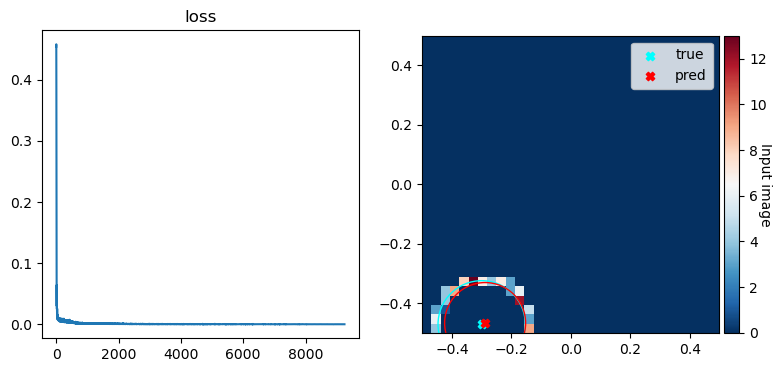

iter 9500 , loss 8.959232e-05 , lr 0.0003
Circle at (0.09,0.28) with variance 0.021
Circle at (0.08,0.28) with variance 0.025


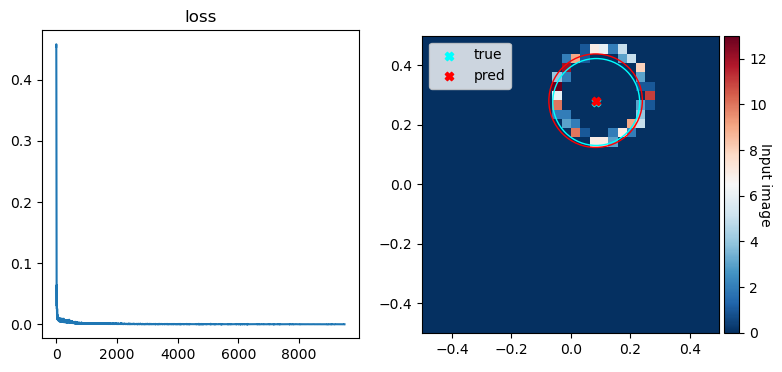

iter 9750 , loss 7.699438e-05 , lr 0.0003
Circle at (0.44,-0.42) with variance 0.047
Circle at (0.42,-0.42) with variance 0.028


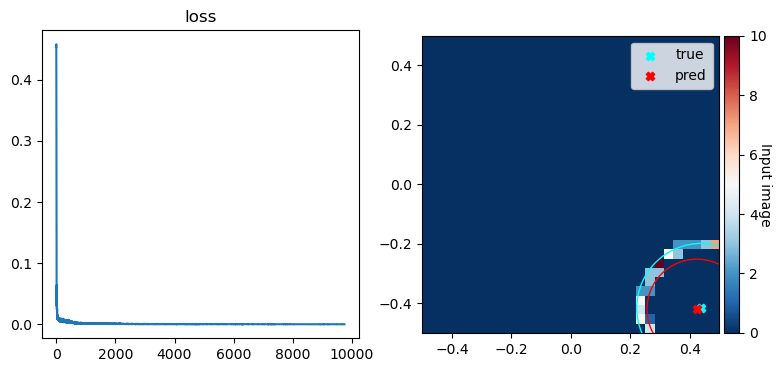

iter 10000 , loss 6.762403e-05 , lr 0.0003
Circle at (0.04,-0.47) with variance 0.023
Circle at (0.05,-0.48) with variance 0.028


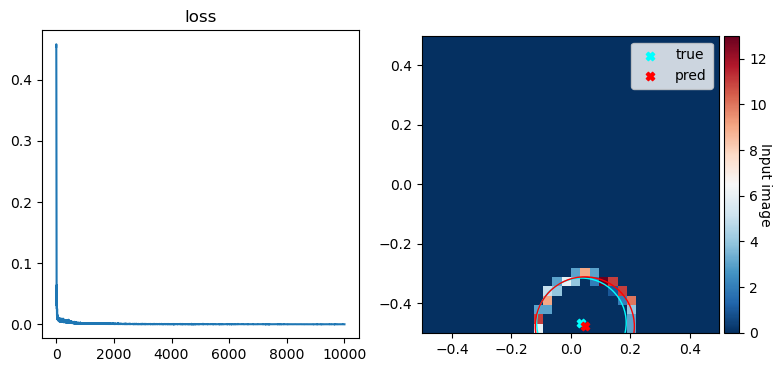

iter 10250 , loss 8.751007e-05 , lr 0.0003
Circle at (0.08,-0.37) with variance 0.023
Circle at (0.09,-0.37) with variance 0.024


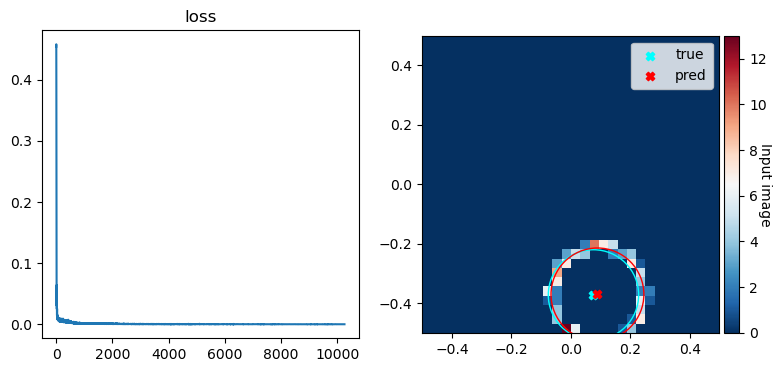

iter 10500 , loss 6.519257e-05 , lr 0.0003
Circle at (-0.13,-0.25) with variance 0.029
Circle at (-0.12,-0.23) with variance 0.026


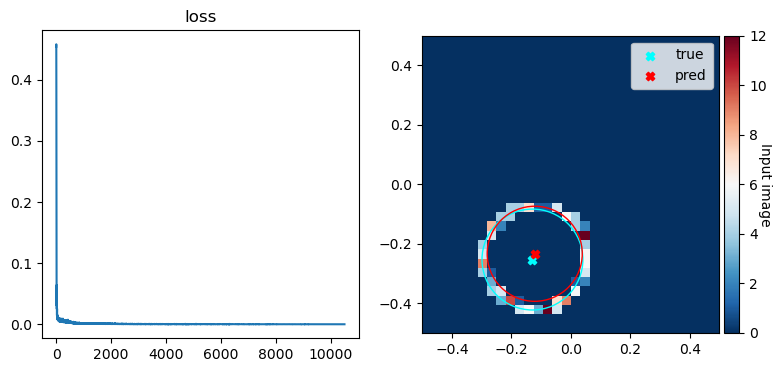

iter 10750 , loss 7.561609e-05 , lr 0.0003
Circle at (0.12,0.00) with variance 0.046
Circle at (0.13,0.01) with variance 0.047


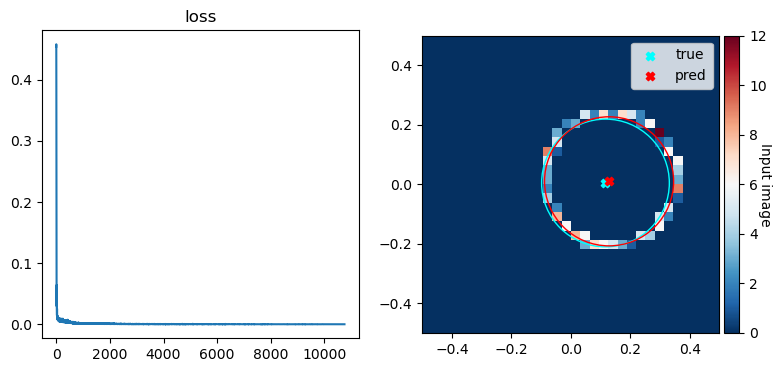

iter 11000 , loss 6.143433e-05 , lr 0.0003
Circle at (0.13,0.01) with variance 0.032
Circle at (0.12,0.01) with variance 0.027


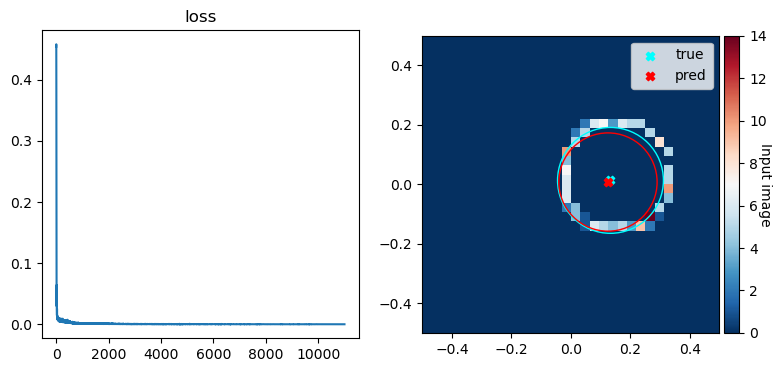

iter 11250 , loss 7.0905764e-05 , lr 0.0003
Circle at (-0.36,0.31) with variance 0.026
Circle at (-0.35,0.29) with variance 0.028


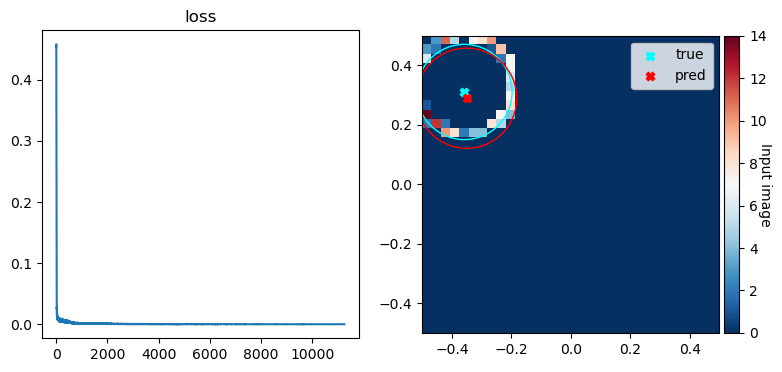

iter 11500 , loss 8.828632e-05 , lr 0.0003
Circle at (0.38,0.38) with variance 0.038
Circle at (0.37,0.36) with variance 0.030


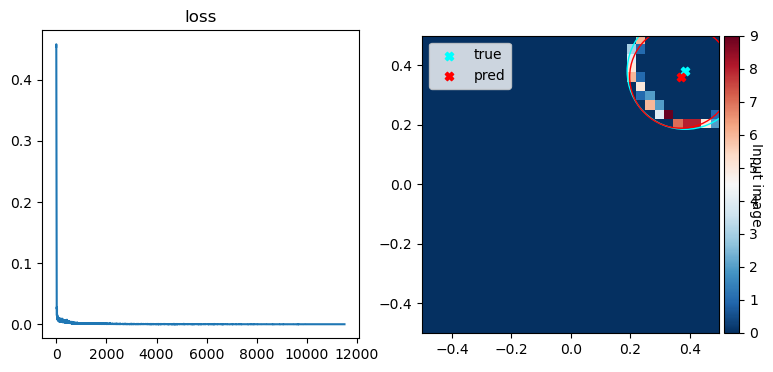

iter 11750 , loss 4.2703672e-05 , lr 0.0003
Circle at (0.19,-0.04) with variance 0.040
Circle at (0.19,-0.04) with variance 0.042


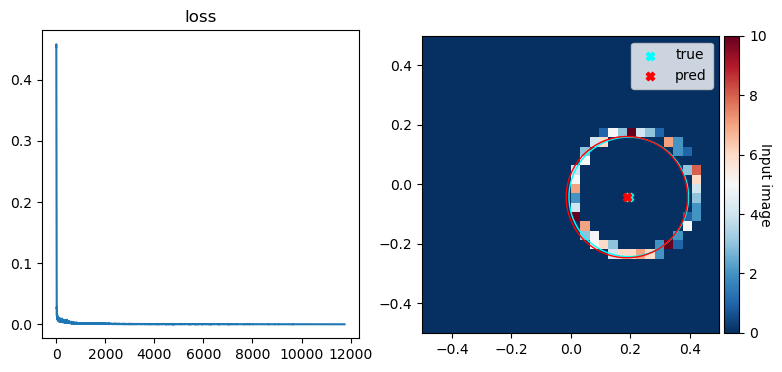

iter 12000 , loss 3.8277387e-05 , lr 0.0003
Circle at (-0.40,0.23) with variance 0.034
Circle at (-0.41,0.24) with variance 0.042


iter 12250 , loss 5.2495016e-05 , lr 0.0003
Circle at (0.46,-0.28) with variance 0.033
Circle at (0.46,-0.29) with variance 0.031


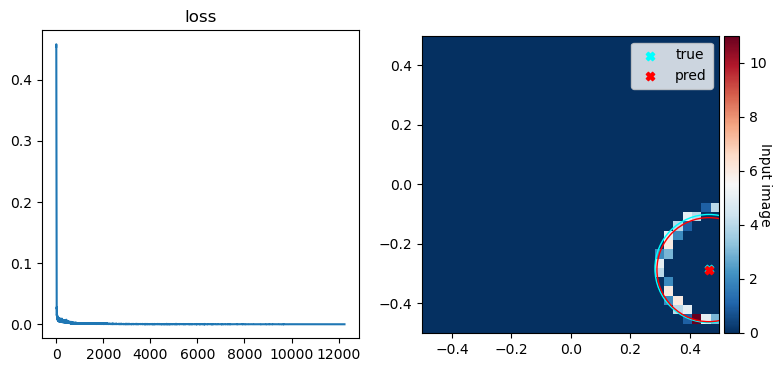

iter 12500 , loss 5.898816e-05 , lr 0.0003
Circle at (0.41,0.31) with variance 0.040
Circle at (0.41,0.31) with variance 0.037


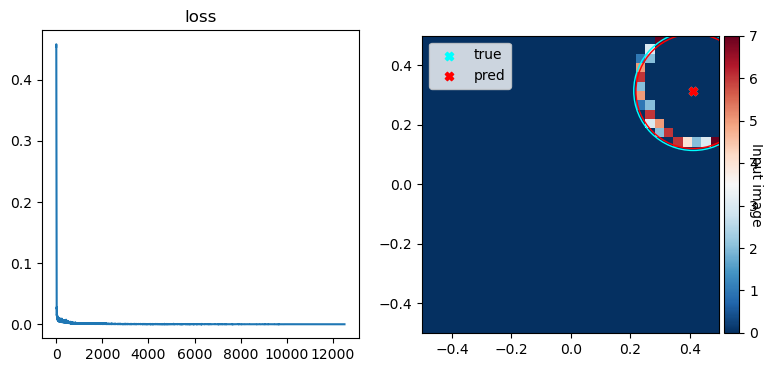

iter 12750 , loss 5.9618324e-05 , lr 0.0003
Circle at (-0.33,0.40) with variance 0.019
Circle at (-0.33,0.39) with variance 0.020


iter 13000 , loss 5.8693702e-05 , lr 0.0003
Circle at (0.16,-0.38) with variance 0.024
Circle at (0.16,-0.38) with variance 0.028


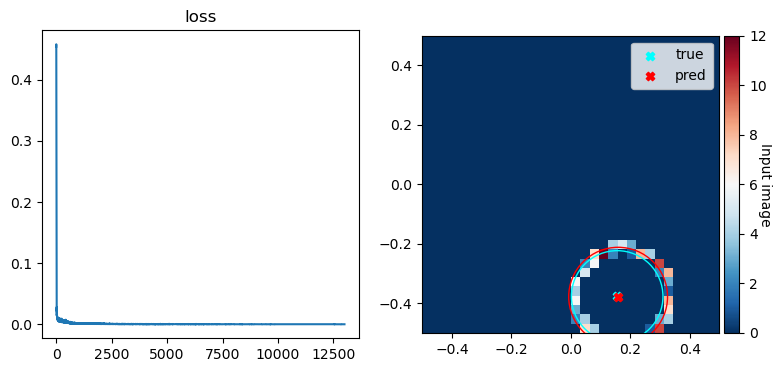

iter 13250 , loss 7.0235255e-05 , lr 0.0003
Circle at (0.44,-0.08) with variance 0.029
Circle at (0.44,-0.08) with variance 0.031


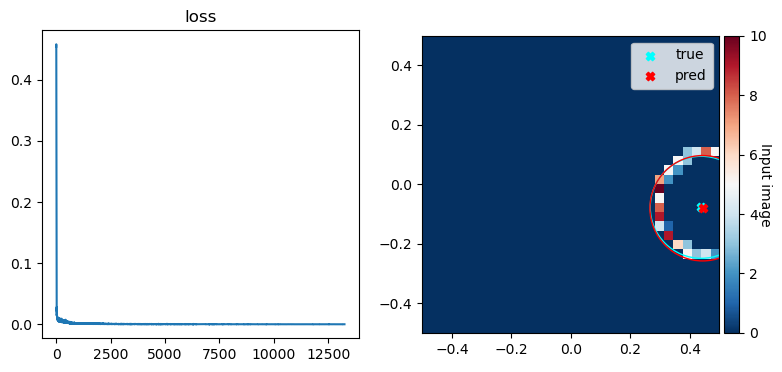

iter 13500 , loss 4.507457e-05 , lr 0.0003
Circle at (0.45,0.19) with variance 0.018
Circle at (0.46,0.19) with variance 0.023


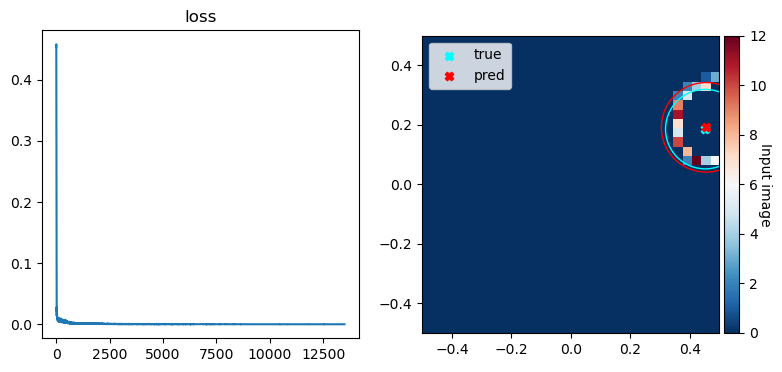

iter 13750 , loss 7.852149e-05 , lr 0.0003
Circle at (-0.22,0.35) with variance 0.044
Circle at (-0.22,0.36) with variance 0.036


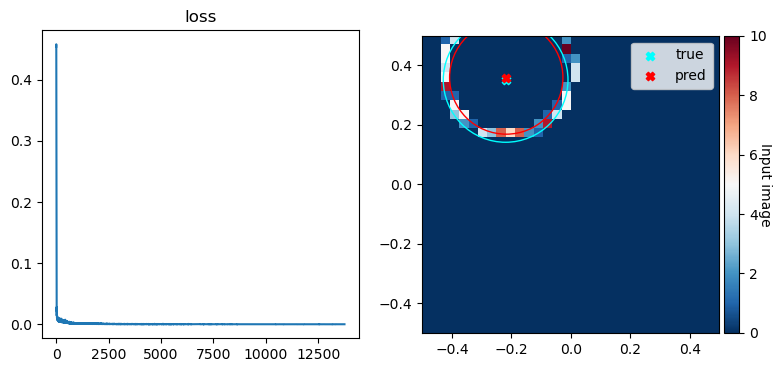

iter 14000 , loss 7.90046e-05 , lr 0.0003
Circle at (0.48,-0.09) with variance 0.030
Circle at (0.48,-0.09) with variance 0.032


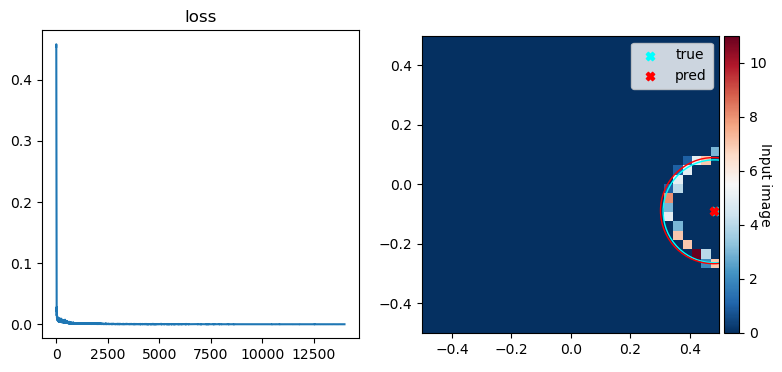

iter 14250 , loss 3.891627e-05 , lr 0.0003
Circle at (-0.25,-0.35) with variance 0.023
Circle at (-0.26,-0.35) with variance 0.028


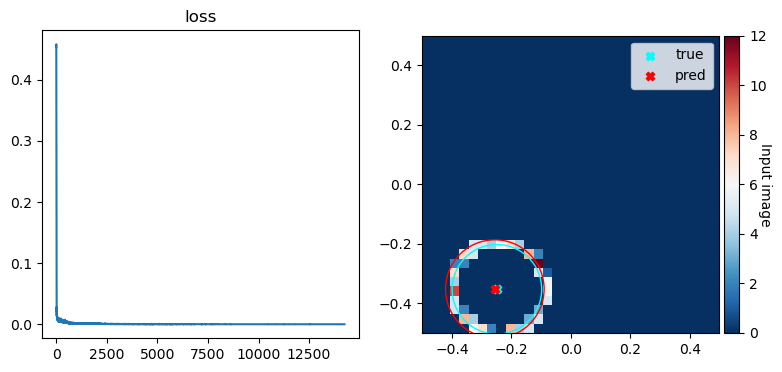

iter 14500 , loss 4.200018e-05 , lr 0.0003
Circle at (0.02,-0.23) with variance 0.012
Circle at (0.01,-0.23) with variance 0.013


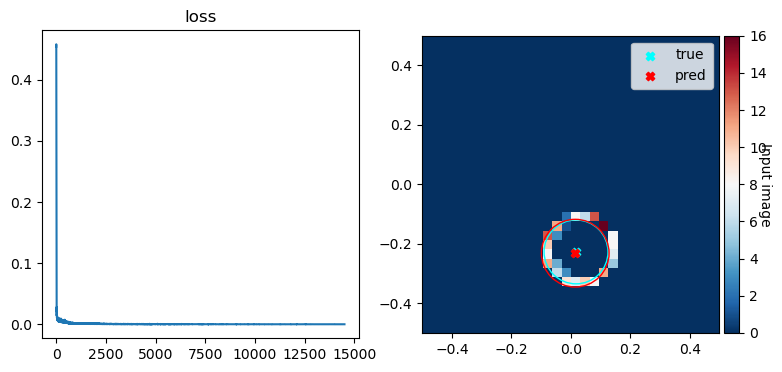

iter 14750 , loss 4.5542773e-05 , lr 0.0003
Circle at (0.41,0.21) with variance 0.020
Circle at (0.40,0.20) with variance 0.021


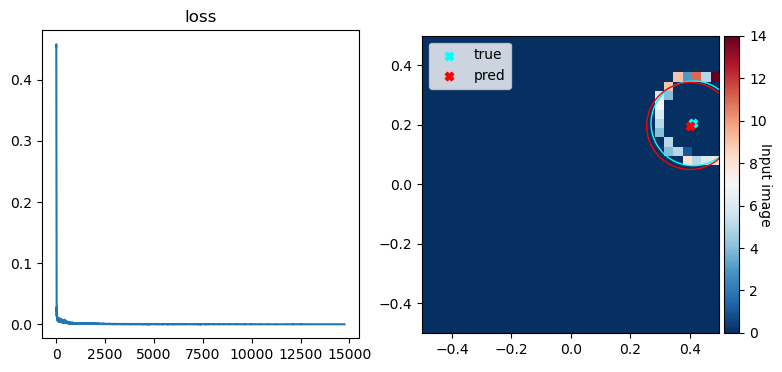

iter 15000 , loss 5.9508628e-05 , lr 0.0003
Circle at (-0.15,0.13) with variance 0.020
Circle at (-0.15,0.14) with variance 0.020


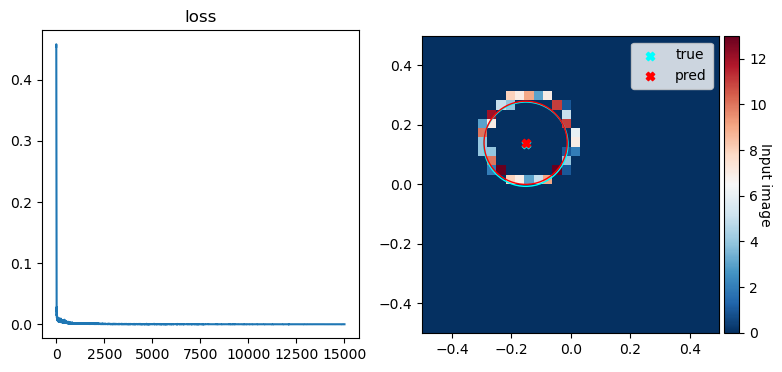

iter 15250 , loss 3.8971495e-05 , lr 0.0003
Circle at (0.38,-0.04) with variance 0.038
Circle at (0.38,-0.05) with variance 0.039


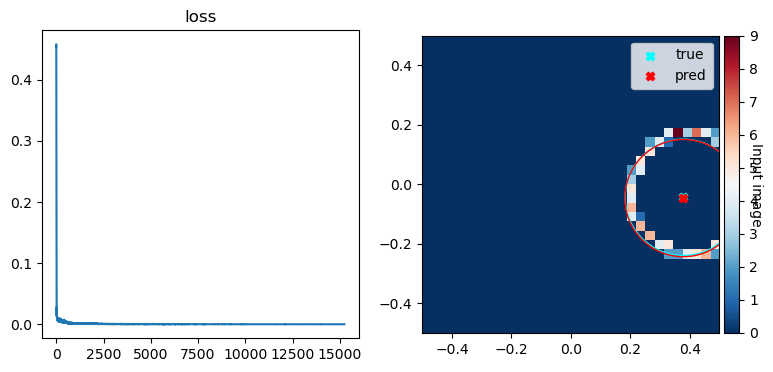

iter 15500 , loss 7.3817064e-05 , lr 0.0003
Circle at (0.39,-0.37) with variance 0.016
Circle at (0.39,-0.36) with variance 0.023


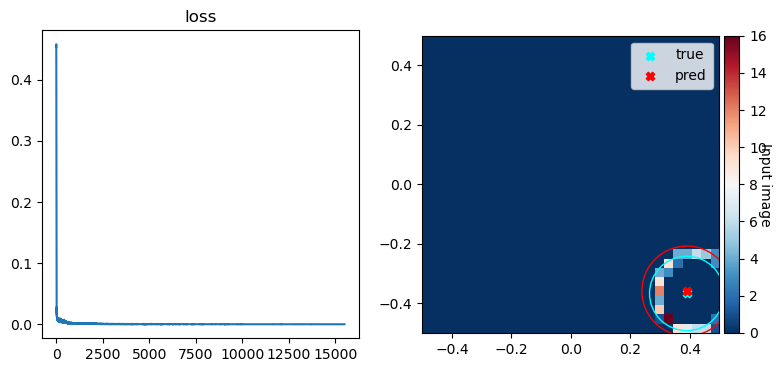

iter 15750 , loss 5.5544864e-05 , lr 0.0003
Circle at (-0.24,0.10) with variance 0.049
Circle at (-0.24,0.09) with variance 0.043


iter 16000 , loss 3.5850124e-05 , lr 0.0003
Circle at (0.11,-0.16) with variance 0.026
Circle at (0.12,-0.16) with variance 0.021


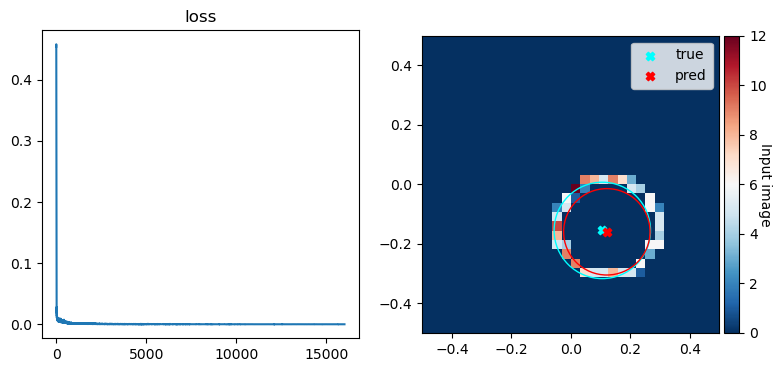

iter 16250 , loss 3.664328e-05 , lr 0.0003
Circle at (0.26,0.20) with variance 0.048
Circle at (0.26,0.19) with variance 0.046


iter 16500 , loss 4.8407317e-05 , lr 0.0003
Circle at (0.39,-0.34) with variance 0.027
Circle at (0.39,-0.33) with variance 0.030


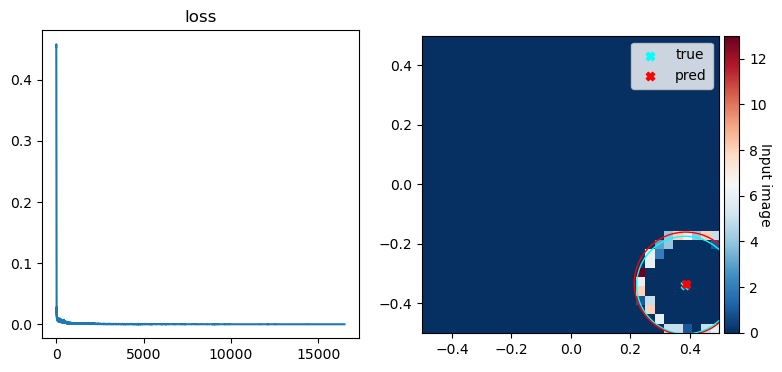

iter 16750 , loss 7.737707e-05 , lr 0.0003
Circle at (-0.41,-0.07) with variance 0.028
Circle at (-0.41,-0.07) with variance 0.030


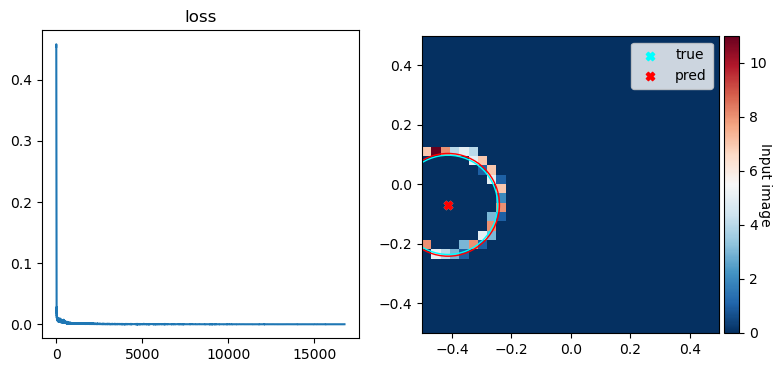

iter 17000 , loss 4.067358e-05 , lr 0.0003
Circle at (0.29,-0.01) with variance 0.017
Circle at (0.29,-0.00) with variance 0.021


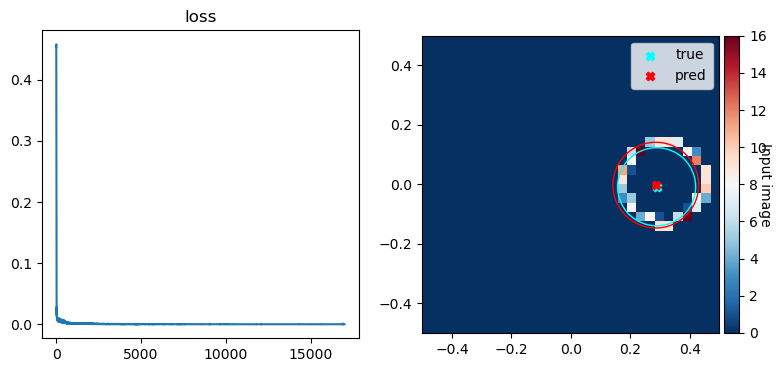

iter 17250 , loss 3.5805875e-05 , lr 0.0003
Circle at (-0.30,0.33) with variance 0.035
Circle at (-0.31,0.33) with variance 0.036


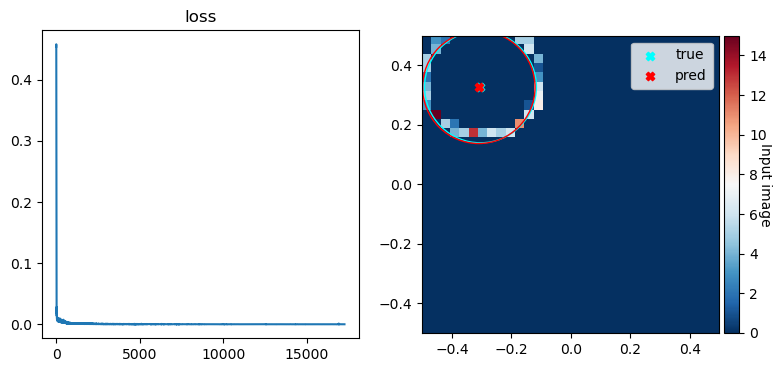

iter 17500 , loss 4.1671985e-05 , lr 0.0003
Circle at (-0.09,-0.34) with variance 0.014
Circle at (-0.09,-0.32) with variance 0.016


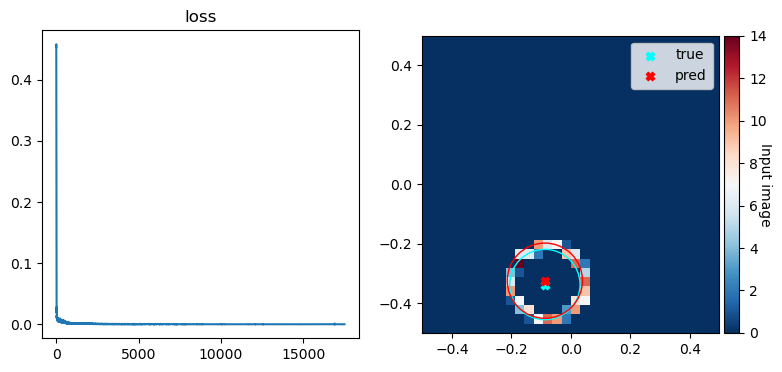

iter 17750 , loss 6.1045284e-05 , lr 0.0003
Circle at (-0.46,-0.01) with variance 0.029
Circle at (-0.48,-0.01) with variance 0.032


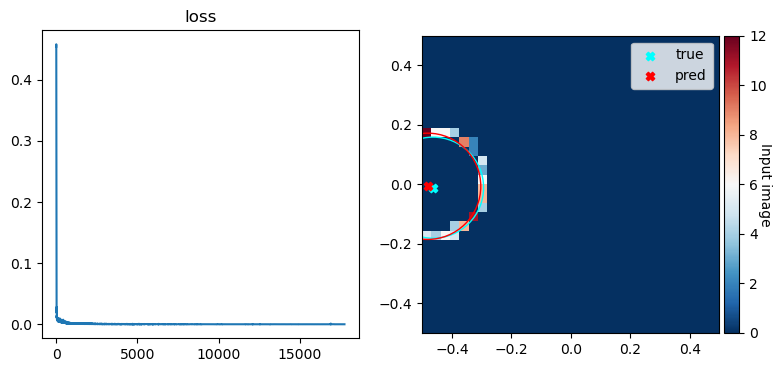

iter 18000 , loss 5.5810786e-05 , lr 0.0003
Circle at (-0.33,-0.41) with variance 0.040
Circle at (-0.33,-0.41) with variance 0.037


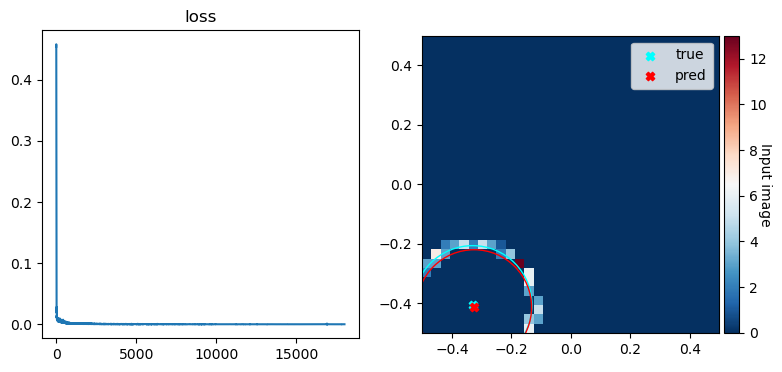

iter 18250 , loss 7.169115e-05 , lr 0.0003
Circle at (-0.18,0.04) with variance 0.032
Circle at (-0.18,0.06) with variance 0.027


iter 18500 , loss 4.36536e-05 , lr 0.0003
Circle at (-0.47,-0.21) with variance 0.047
Circle at (-0.46,-0.21) with variance 0.040


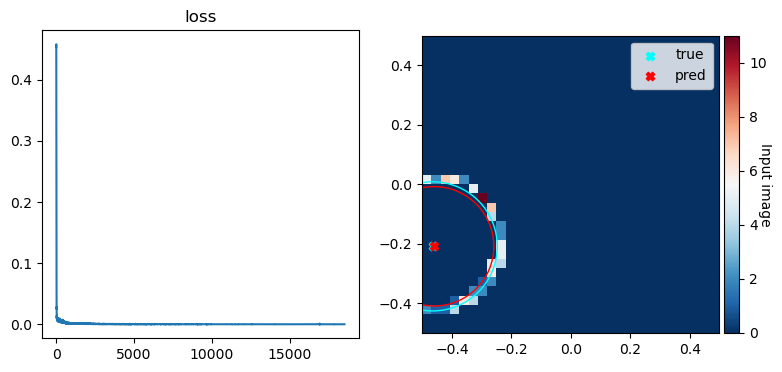

iter 18750 , loss 4.343174e-05 , lr 0.0003
Circle at (-0.31,-0.27) with variance 0.048
Circle at (-0.31,-0.28) with variance 0.047


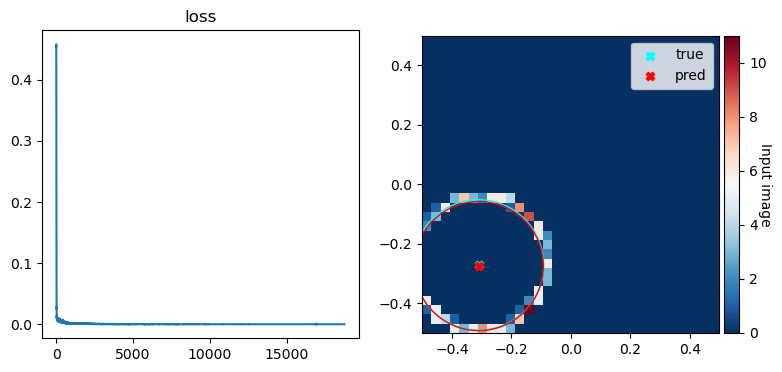

iter 19000 , loss 4.459578e-05 , lr 0.0003
Circle at (0.25,0.41) with variance 0.042
Circle at (0.25,0.40) with variance 0.041


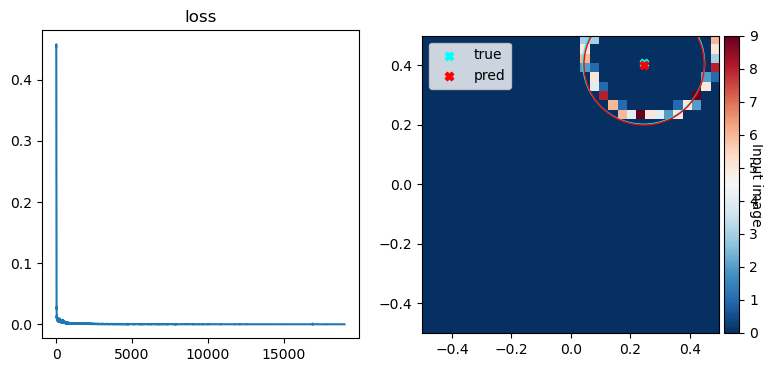

iter 19250 , loss 5.0175644e-05 , lr 0.0003
Circle at (0.40,-0.30) with variance 0.014
Circle at (0.38,-0.29) with variance 0.019


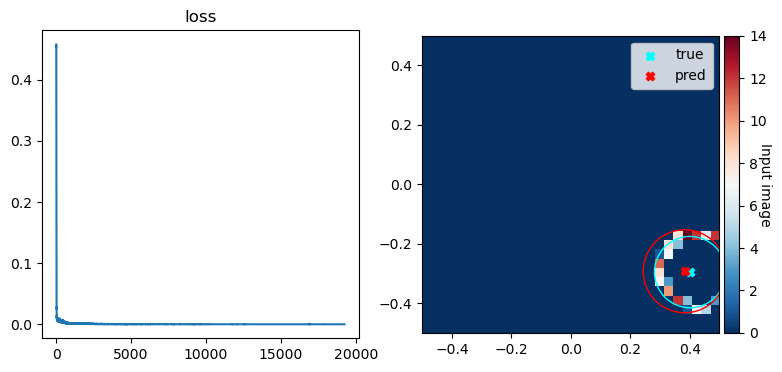

iter 19500 , loss 2.55381e-05 , lr 0.0003
Circle at (0.09,0.42) with variance 0.028
Circle at (0.09,0.42) with variance 0.025


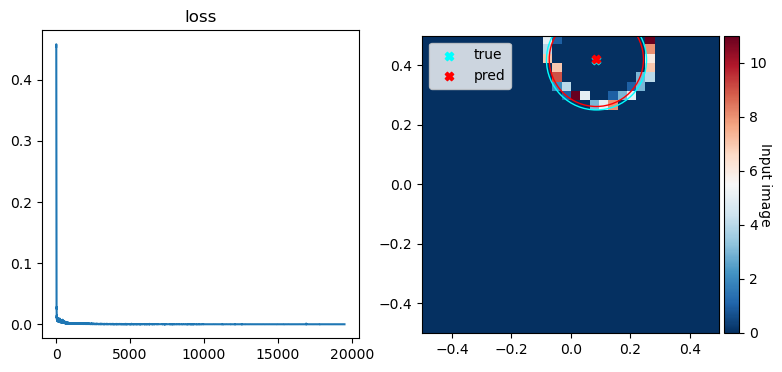

iter 19750 , loss 3.3835247e-05 , lr 0.0003
Circle at (-0.41,0.11) with variance 0.036
Circle at (-0.42,0.11) with variance 0.038


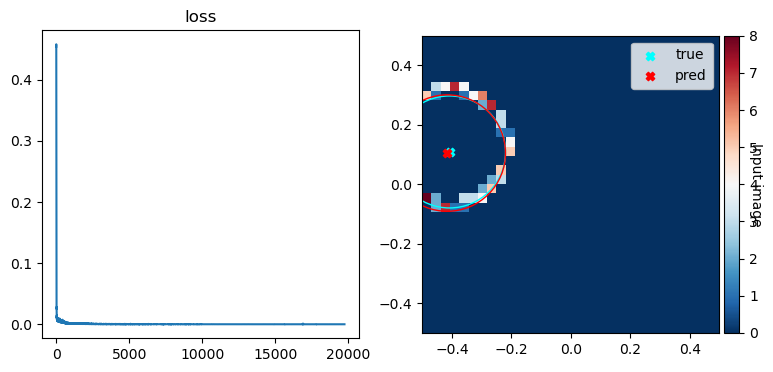

iter 20000 , loss 3.817632e-05 , lr 0.0003
Circle at (-0.19,0.04) with variance 0.012
Circle at (-0.19,0.04) with variance 0.014


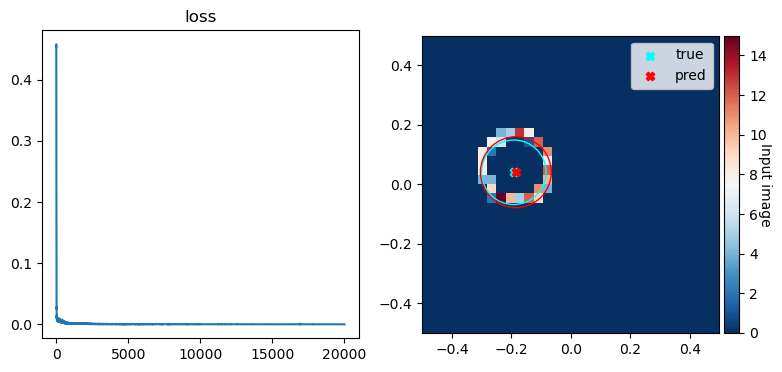

iter 20250 , loss 3.4245128e-05 , lr 0.0003
Circle at (0.47,-0.01) with variance 0.047
Circle at (0.47,-0.01) with variance 0.039


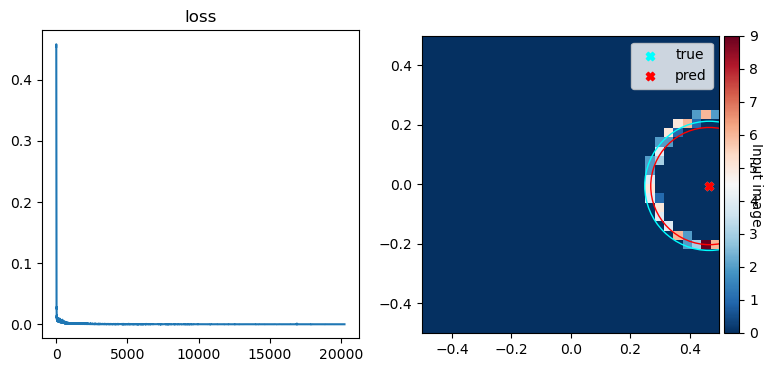

iter 20500 , loss 2.3384415e-05 , lr 0.0003
Circle at (0.06,-0.41) with variance 0.044
Circle at (0.05,-0.40) with variance 0.043


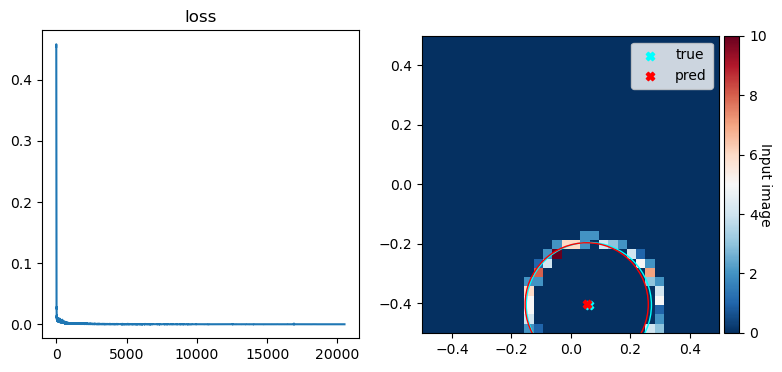

iter 20750 , loss 4.5891396e-05 , lr 0.0003
Circle at (-0.16,0.29) with variance 0.043
Circle at (-0.17,0.29) with variance 0.040


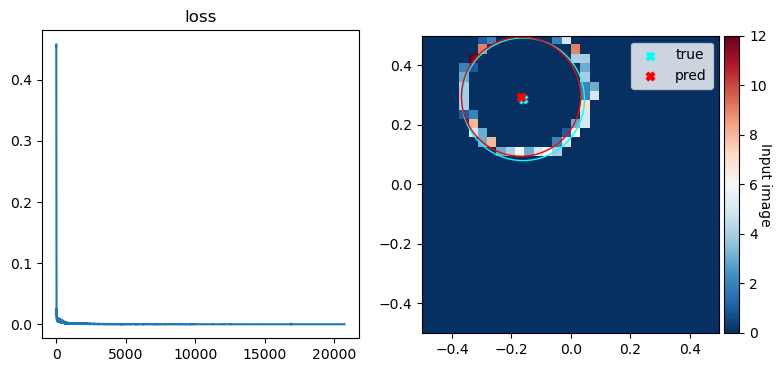

iter 21000 , loss 2.3742925e-05 , lr 0.0003
Circle at (0.01,0.25) with variance 0.035
Circle at (0.00,0.26) with variance 0.039


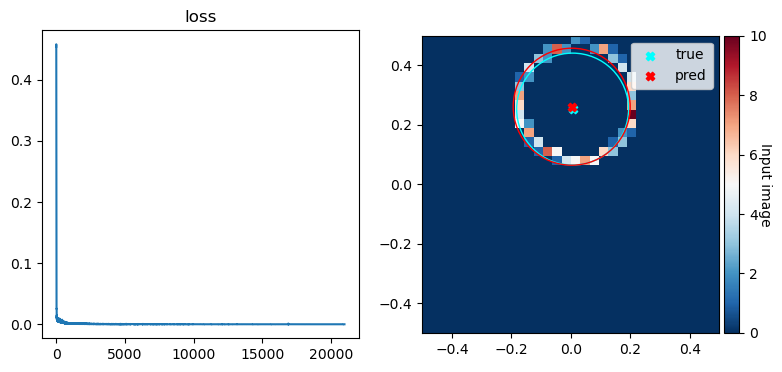

iter 21250 , loss 3.113103e-05 , lr 0.0003
Circle at (-0.08,0.21) with variance 0.048
Circle at (-0.08,0.21) with variance 0.046


iter 21500 , loss 2.9087194e-05 , lr 0.0003
Circle at (-0.02,-0.46) with variance 0.021
Circle at (-0.02,-0.46) with variance 0.023


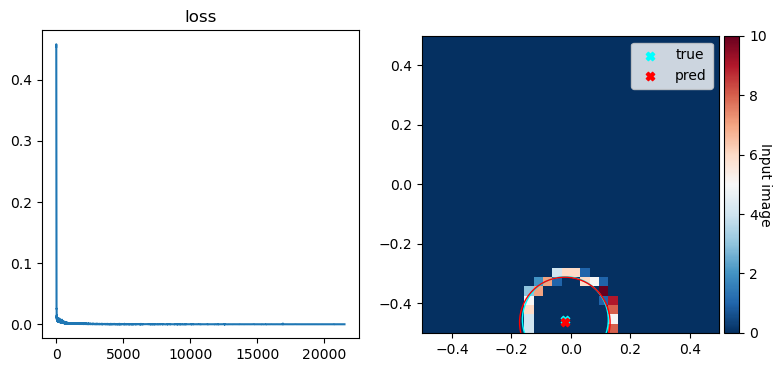

iter 21750 , loss 3.5289668e-05 , lr 0.0003
Circle at (-0.40,0.21) with variance 0.034
Circle at (-0.40,0.22) with variance 0.032


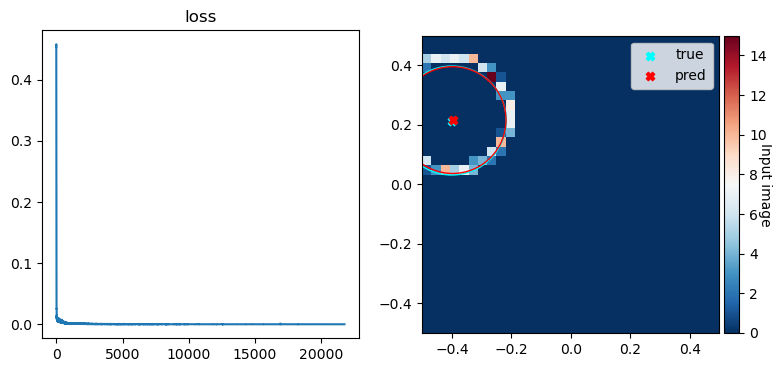

iter 22000 , loss 2.7249458e-05 , lr 0.0003
Circle at (-0.41,-0.43) with variance 0.045
Circle at (-0.41,-0.43) with variance 0.038


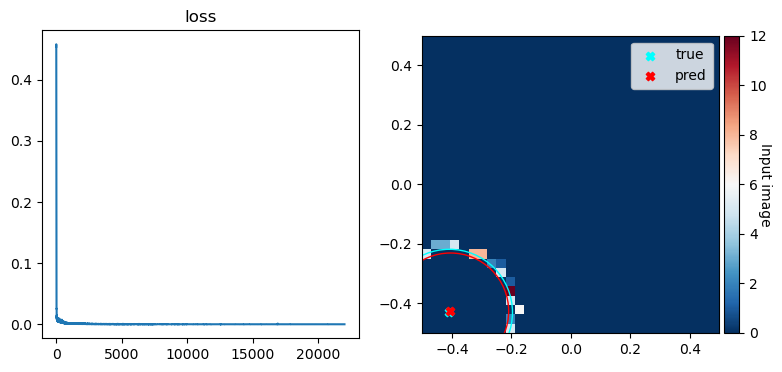

iter 22250 , loss 2.1792175e-05 , lr 0.0003
Circle at (0.42,-0.25) with variance 0.028
Circle at (0.41,-0.25) with variance 0.030


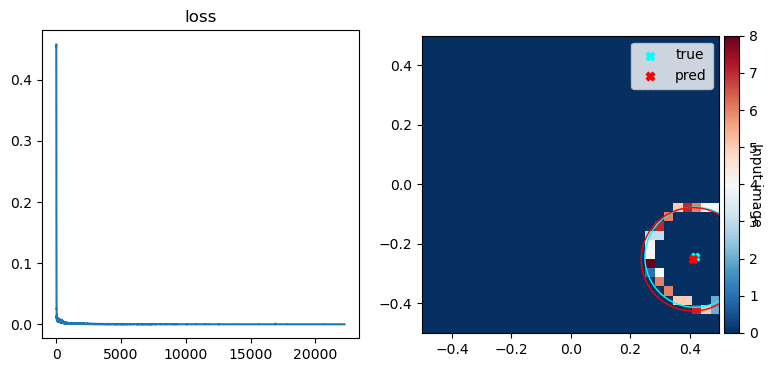

iter 22500 , loss 3.2203567e-05 , lr 0.0003
Circle at (0.22,-0.32) with variance 0.039
Circle at (0.22,-0.31) with variance 0.038


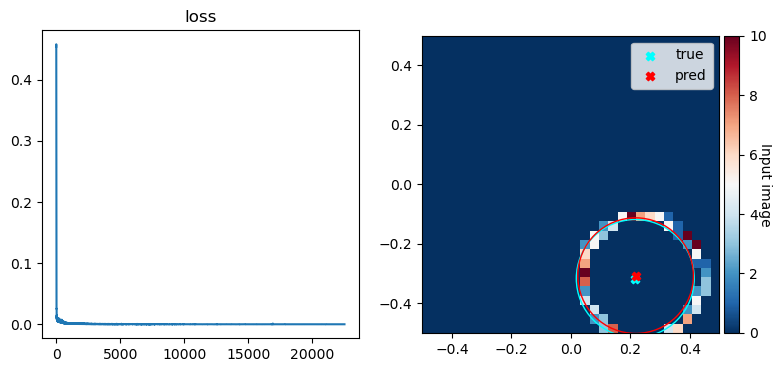

iter 22750 , loss 0.0004956684 , lr 0.0003
Circle at (-0.24,-0.04) with variance 0.048
Circle at (-0.27,-0.06) with variance 0.043


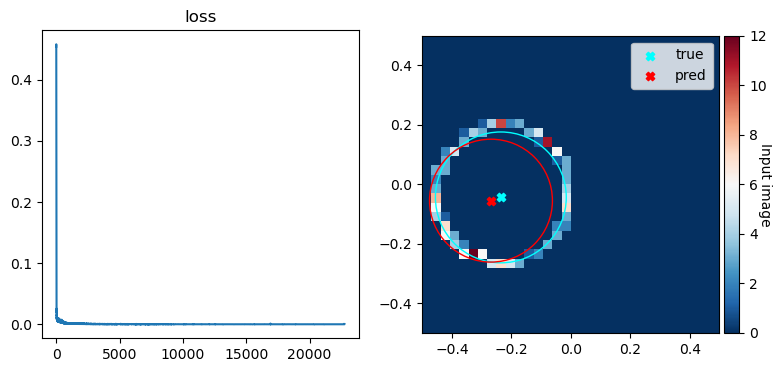

iter 23000 , loss 2.1892814e-05 , lr 0.0003
Circle at (0.36,0.09) with variance 0.047
Circle at (0.36,0.09) with variance 0.047


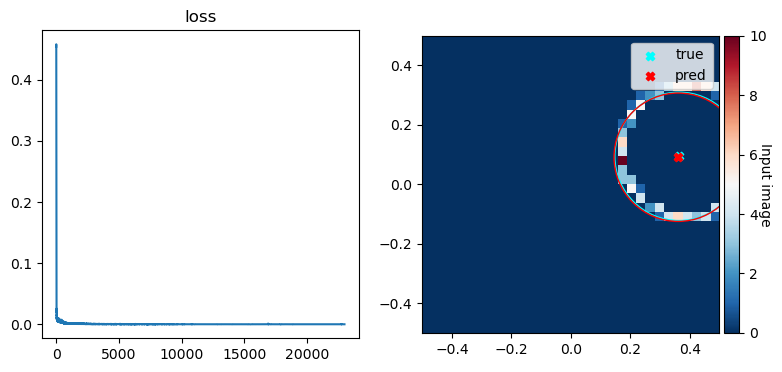

iter 23250 , loss 2.1214812e-05 , lr 0.0003
Circle at (-0.41,-0.15) with variance 0.014
Circle at (-0.41,-0.15) with variance 0.016


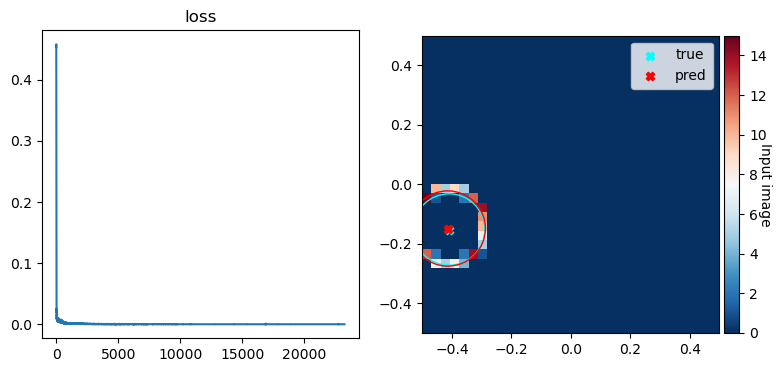

iter 23500 , loss 3.6898346e-05 , lr 0.0003
Circle at (-0.48,-0.19) with variance 0.019
Circle at (-0.48,-0.19) with variance 0.020


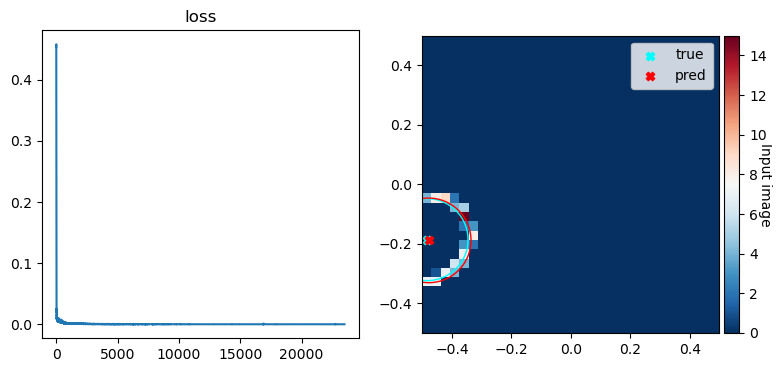

iter 23750 , loss 2.5078814e-05 , lr 0.0003
Circle at (0.18,0.45) with variance 0.045
Circle at (0.18,0.44) with variance 0.043


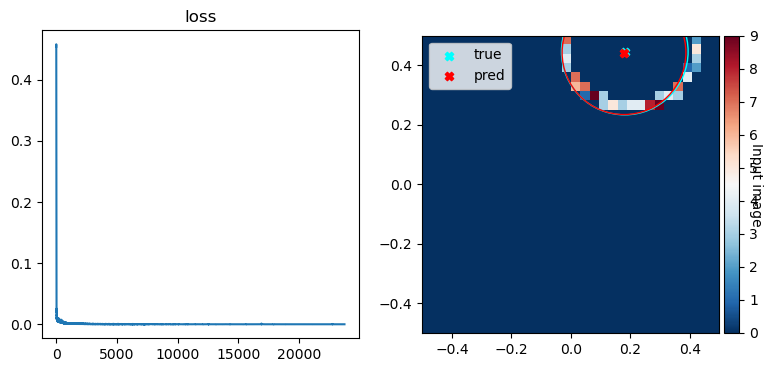

iter 24000 , loss 2.6711108e-05 , lr 0.0003
Circle at (0.42,-0.35) with variance 0.038
Circle at (0.42,-0.35) with variance 0.040


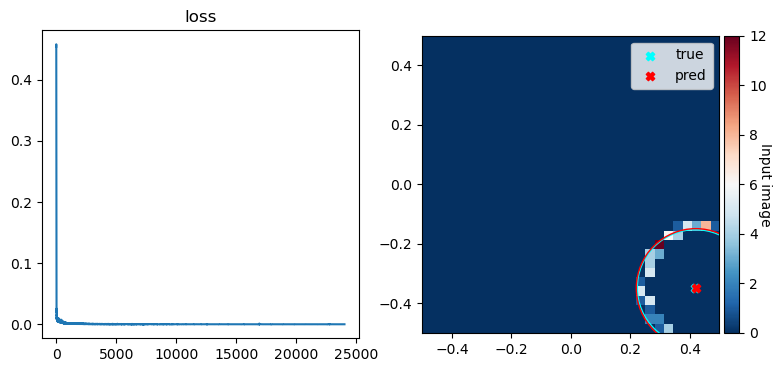

iter 24250 , loss 3.065908e-05 , lr 0.0003
Circle at (0.35,0.08) with variance 0.036
Circle at (0.35,0.09) with variance 0.039


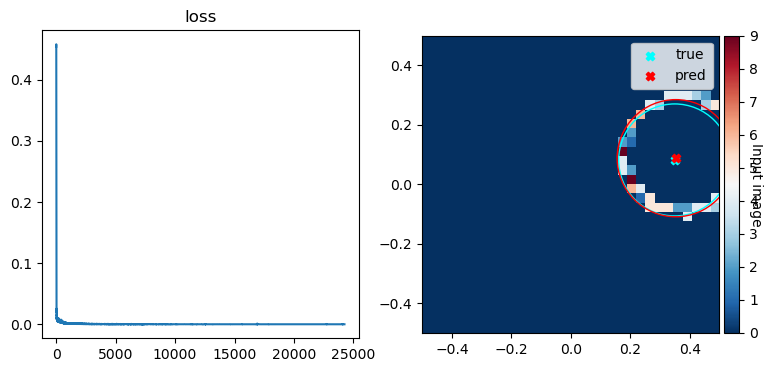

iter 24500 , loss 3.5668745e-05 , lr 0.0003
Circle at (-0.41,-0.37) with variance 0.028
Circle at (-0.42,-0.37) with variance 0.029


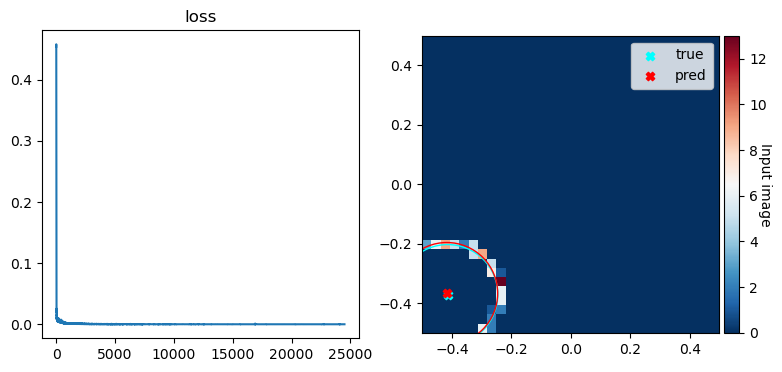

iter 24750 , loss 2.6833352e-05 , lr 0.0003
Circle at (0.23,-0.24) with variance 0.012
Circle at (0.23,-0.24) with variance 0.017


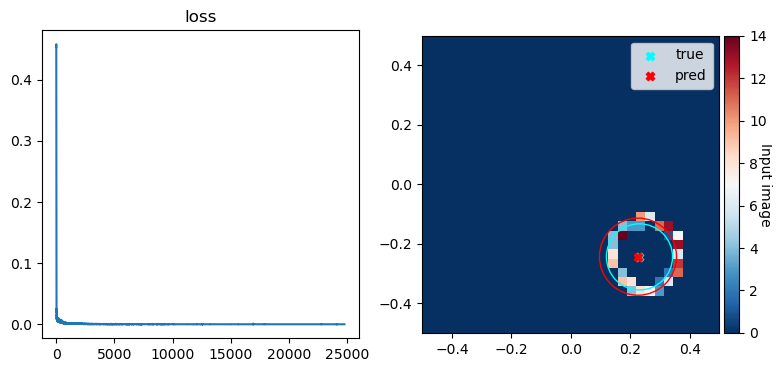

iter 25000 , loss 2.7540014e-05 , lr 0.0003
Circle at (-0.13,-0.39) with variance 0.017
Circle at (-0.12,-0.39) with variance 0.017


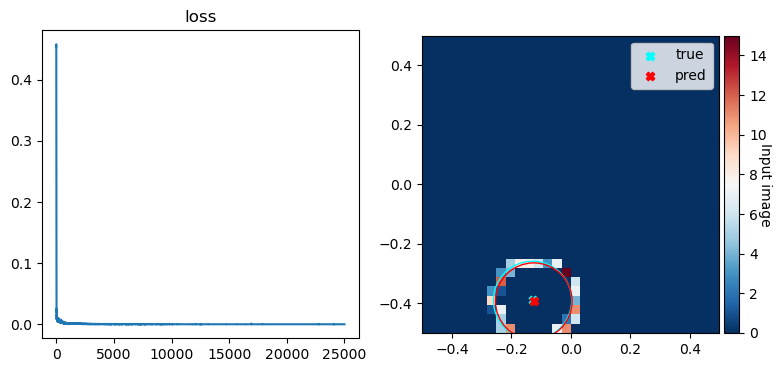

iter 25250 , loss 5.0207193e-05 , lr 0.0003
Circle at (-0.30,0.05) with variance 0.035
Circle at (-0.29,0.05) with variance 0.032


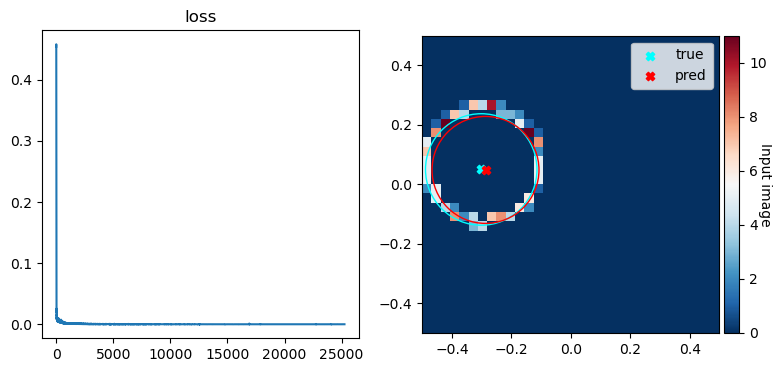

iter 25500 , loss 1.721203e-05 , lr 0.0003
Circle at (0.24,0.23) with variance 0.014
Circle at (0.24,0.23) with variance 0.018


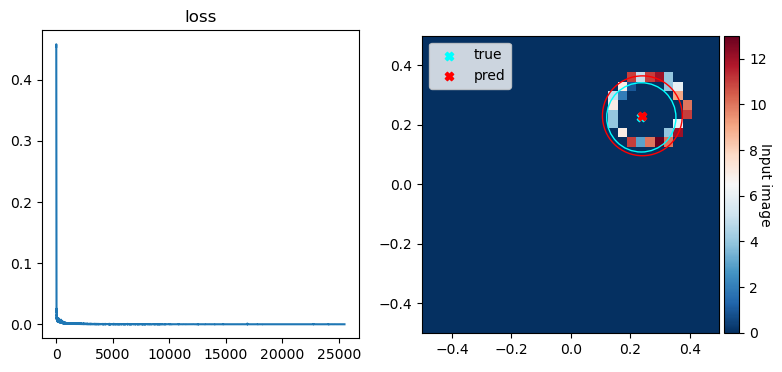

iter 25750 , loss 3.3770193e-05 , lr 0.0003
Circle at (-0.24,0.34) with variance 0.017
Circle at (-0.23,0.34) with variance 0.019


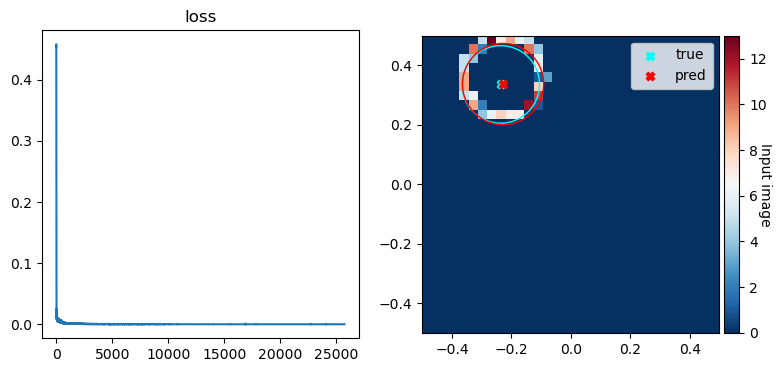

iter 26000 , loss 2.9406408e-05 , lr 0.0003
Circle at (-0.24,-0.42) with variance 0.037
Circle at (-0.24,-0.41) with variance 0.036


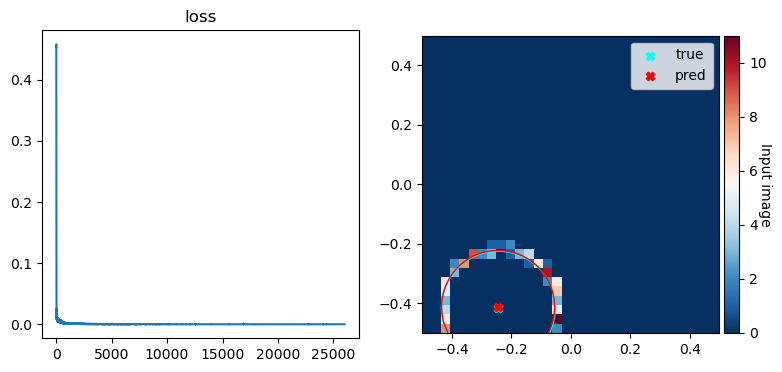

iter 26250 , loss 4.4801905e-05 , lr 0.0003
Circle at (0.40,-0.21) with variance 0.039
Circle at (0.40,-0.21) with variance 0.038


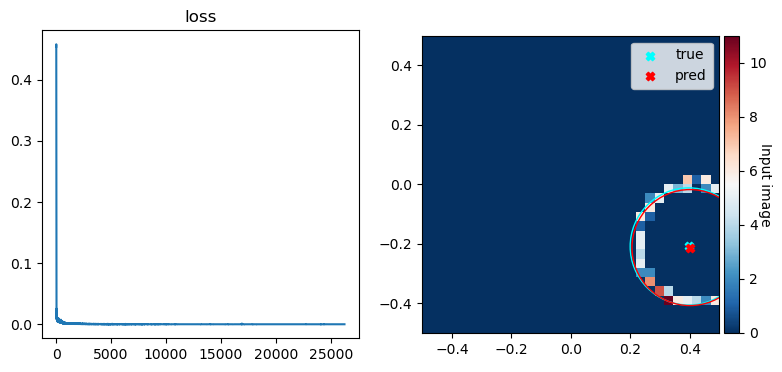

iter 26500 , loss 1.9417685e-05 , lr 0.0003
Circle at (-0.41,-0.13) with variance 0.030
Circle at (-0.41,-0.13) with variance 0.036


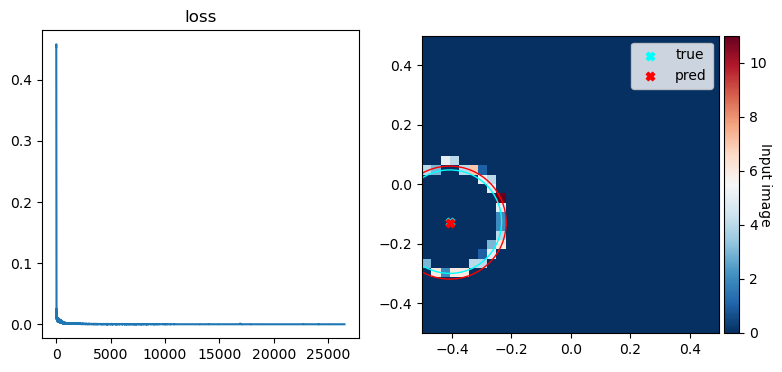

iter 26750 , loss 4.1570427e-05 , lr 0.0003
Circle at (-0.34,0.13) with variance 0.028
Circle at (-0.34,0.14) with variance 0.030


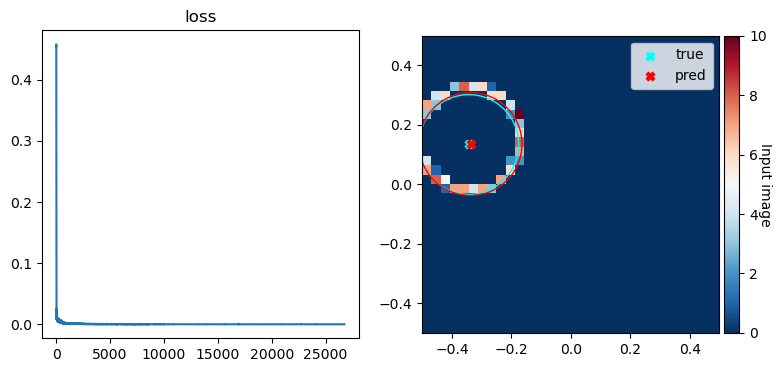

iter 27000 , loss 2.2284668e-05 , lr 0.0003
Circle at (0.21,-0.07) with variance 0.028
Circle at (0.21,-0.07) with variance 0.031


iter 27250 , loss 2.3047181e-05 , lr 0.0003
Circle at (-0.48,0.47) with variance 0.025
Circle at (-0.47,0.46) with variance 0.022


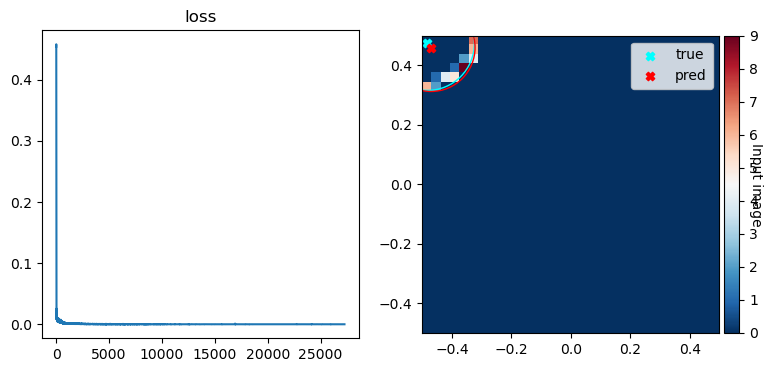

iter 27500 , loss 2.0777283e-05 , lr 0.0003
Circle at (-0.41,-0.16) with variance 0.048
Circle at (-0.40,-0.16) with variance 0.043


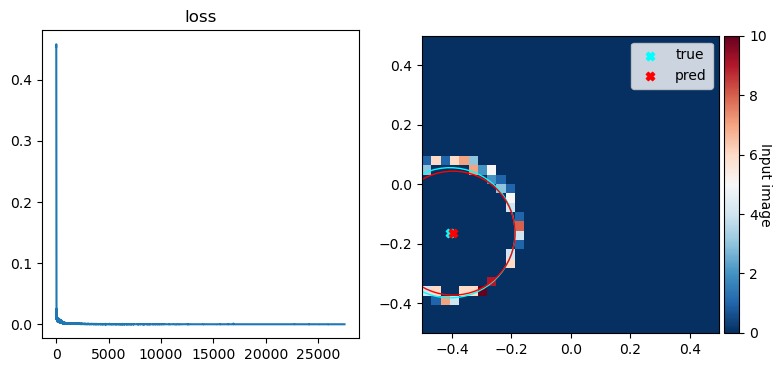

iter 27750 , loss 3.3837445e-05 , lr 0.0003
Circle at (-0.28,-0.05) with variance 0.020
Circle at (-0.28,-0.05) with variance 0.021


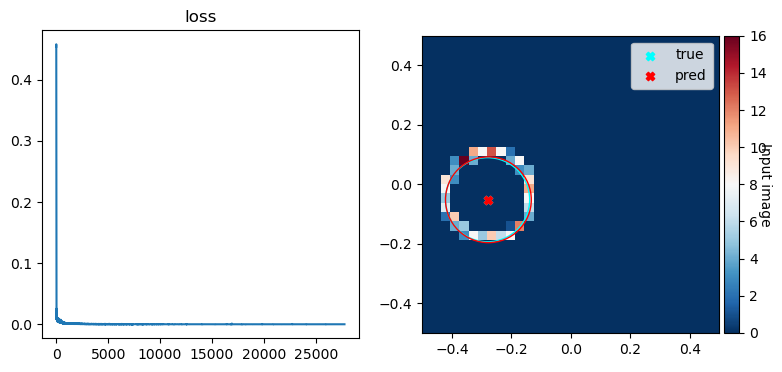

iter 28000 , loss 2.4834586e-05 , lr 0.0003
Circle at (-0.45,-0.49) with variance 0.038
Circle at (-0.45,-0.48) with variance 0.031


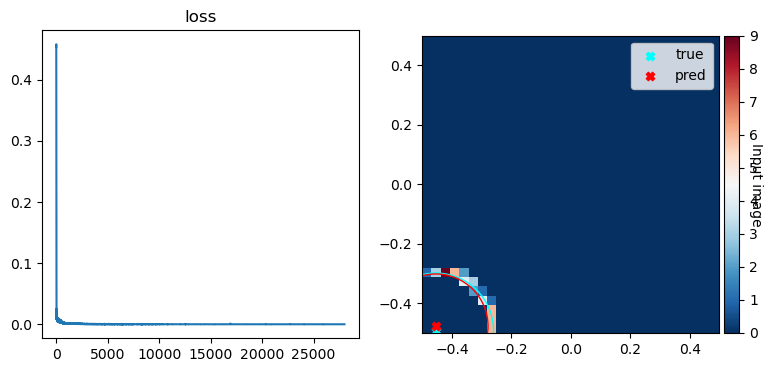

iter 28250 , loss 1.7506329e-05 , lr 0.0003
Circle at (-0.27,0.09) with variance 0.016
Circle at (-0.27,0.09) with variance 0.016


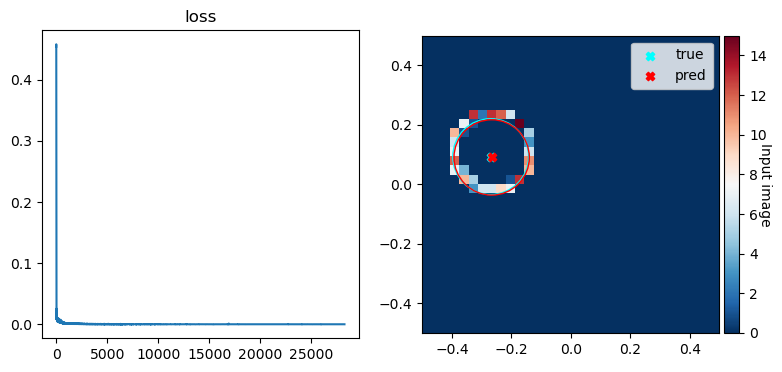

iter 28500 , loss 2.2052793e-05 , lr 0.0003
Circle at (-0.21,0.16) with variance 0.016
Circle at (-0.21,0.16) with variance 0.017


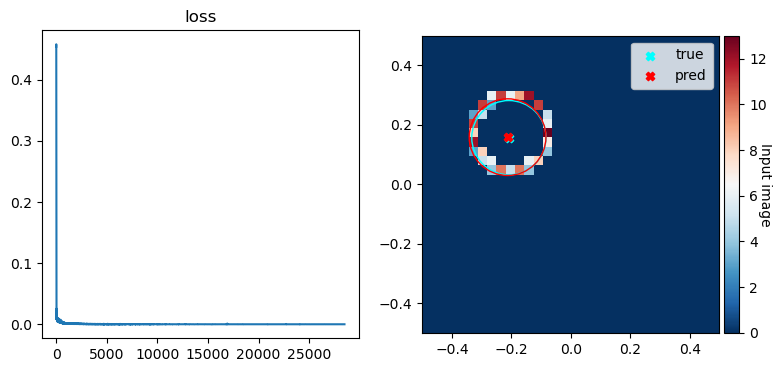

iter 28750 , loss 3.4414385e-05 , lr 0.0003
Circle at (-0.42,0.27) with variance 0.035
Circle at (-0.44,0.28) with variance 0.036


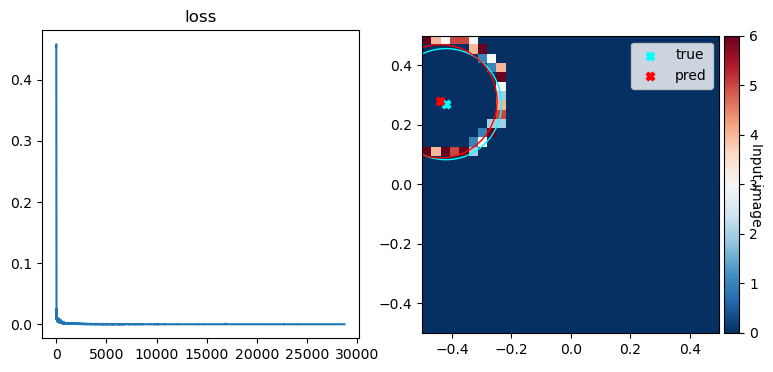

iter 29000 , loss 2.7702357e-05 , lr 0.0003
Circle at (0.23,-0.13) with variance 0.027
Circle at (0.23,-0.13) with variance 0.027


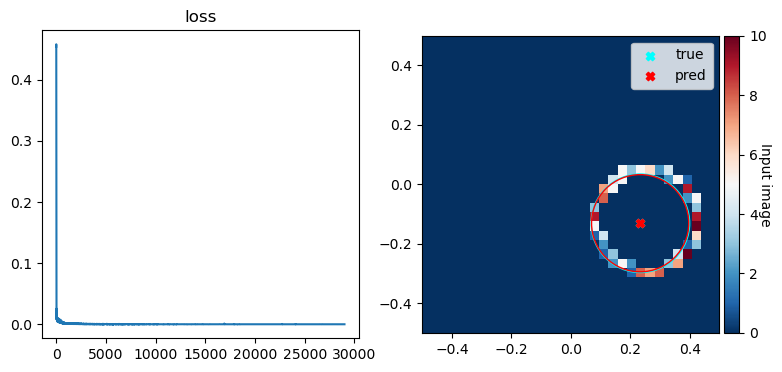

iter 29250 , loss 2.1345097e-05 , lr 0.0003
Circle at (0.02,0.48) with variance 0.041
Circle at (0.02,0.48) with variance 0.042


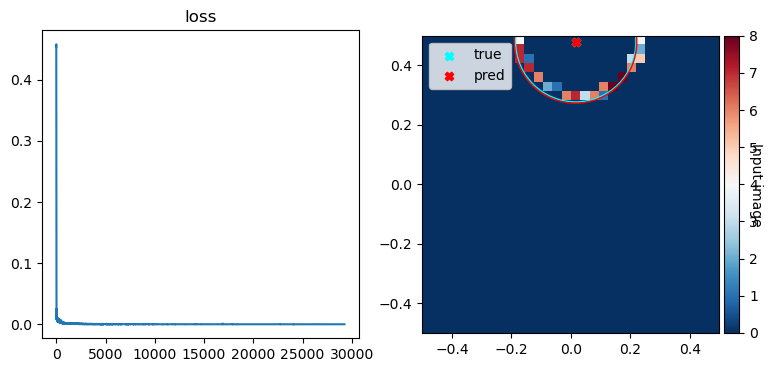

iter 29500 , loss 2.9617715e-05 , lr 0.0003
Circle at (0.49,0.35) with variance 0.040
Circle at (0.48,0.34) with variance 0.033


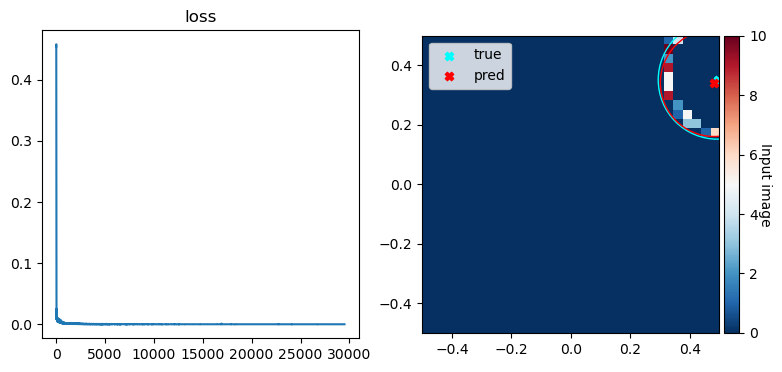

iter 29750 , loss 3.9907467e-05 , lr 0.0003
Circle at (0.50,-0.07) with variance 0.028
Circle at (0.48,-0.06) with variance 0.022


iter 30000 , loss 2.540193e-05 , lr 0.0003
Circle at (0.40,-0.12) with variance 0.037
Circle at (0.40,-0.13) with variance 0.038


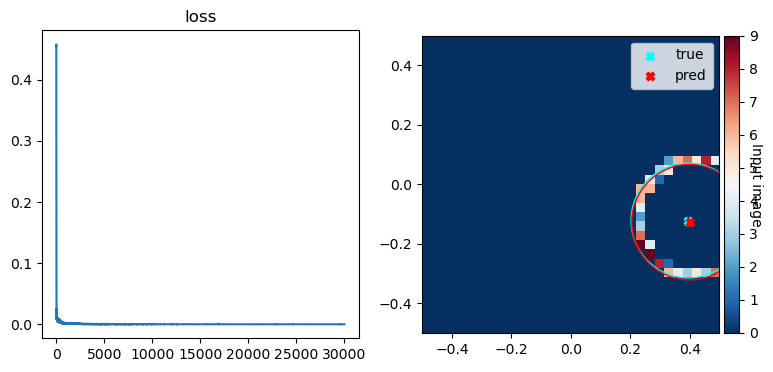

iter 30250 , loss 2.7262122e-05 , lr 0.0003
Circle at (0.12,-0.24) with variance 0.011
Circle at (0.12,-0.23) with variance 0.012


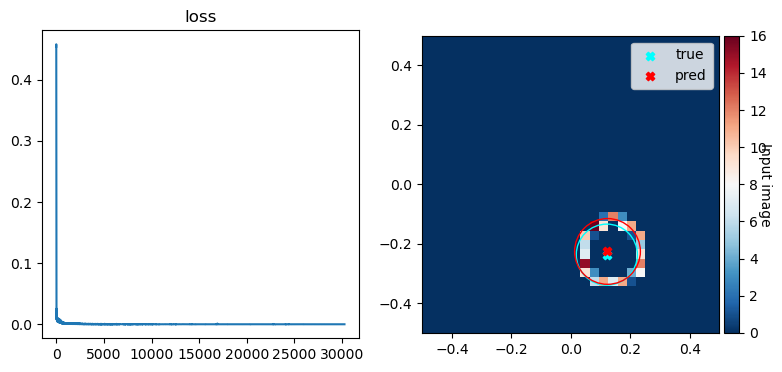

iter 30500 , loss 2.2163189e-05 , lr 0.0003
Circle at (-0.37,-0.42) with variance 0.029
Circle at (-0.37,-0.42) with variance 0.032


iter 30750 , loss 4.1832645e-05 , lr 0.0003
Circle at (-0.47,0.34) with variance 0.047
Circle at (-0.46,0.32) with variance 0.037


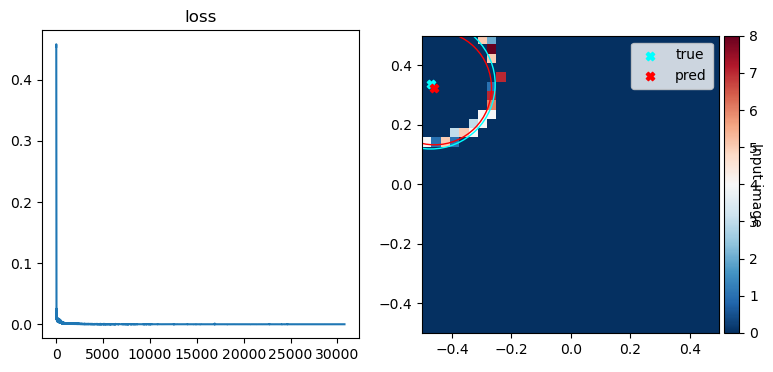

iter 31000 , loss 1.4193417e-05 , lr 0.0003
Circle at (0.32,0.45) with variance 0.039
Circle at (0.31,0.45) with variance 0.040


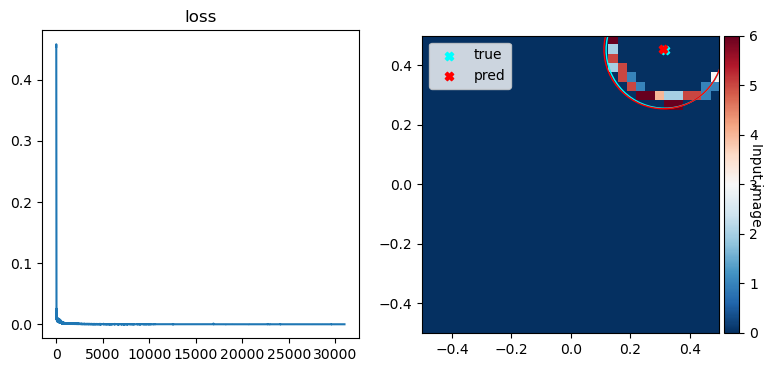

iter 31250 , loss 2.8994134e-05 , lr 0.0003
Circle at (-0.35,-0.19) with variance 0.021
Circle at (-0.35,-0.18) with variance 0.025


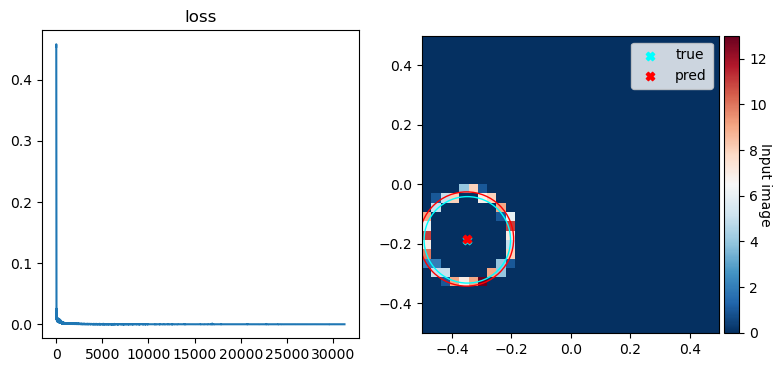

iter 31500 , loss 3.0037332e-05 , lr 0.0003
Circle at (0.41,0.19) with variance 0.042
Circle at (0.40,0.19) with variance 0.044


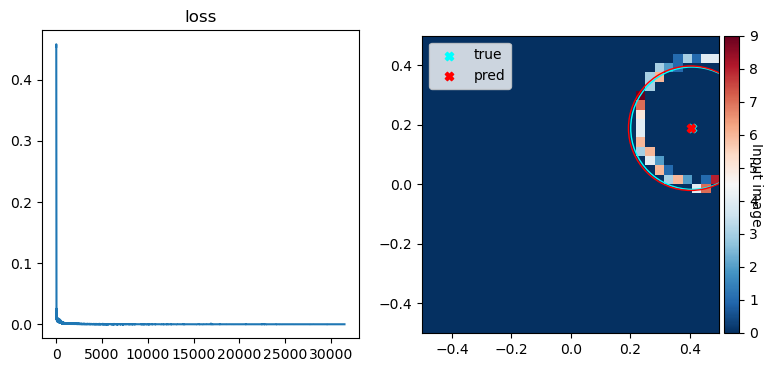

iter 31750 , loss 2.3896733e-05 , lr 0.0003
Circle at (-0.19,-0.26) with variance 0.016
Circle at (-0.19,-0.26) with variance 0.016


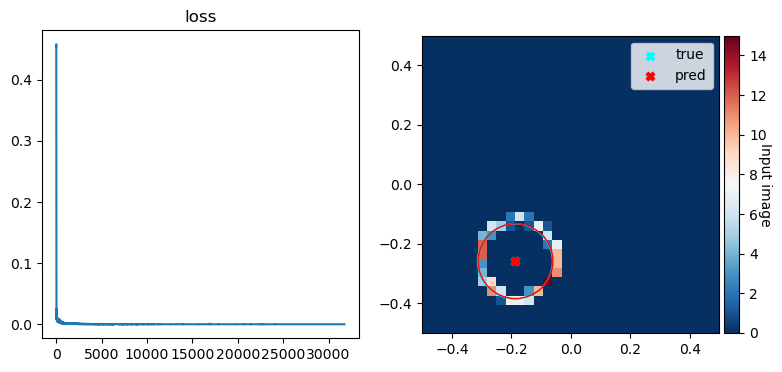

iter 32000 , loss 1.9777726e-05 , lr 0.0003
Circle at (-0.40,0.33) with variance 0.047
Circle at (-0.40,0.34) with variance 0.045


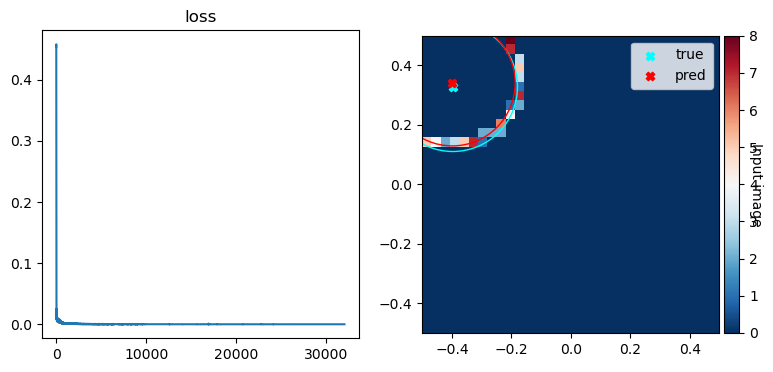

iter 32250 , loss 2.9249863e-05 , lr 0.0003
Circle at (0.19,-0.12) with variance 0.020
Circle at (0.19,-0.12) with variance 0.017


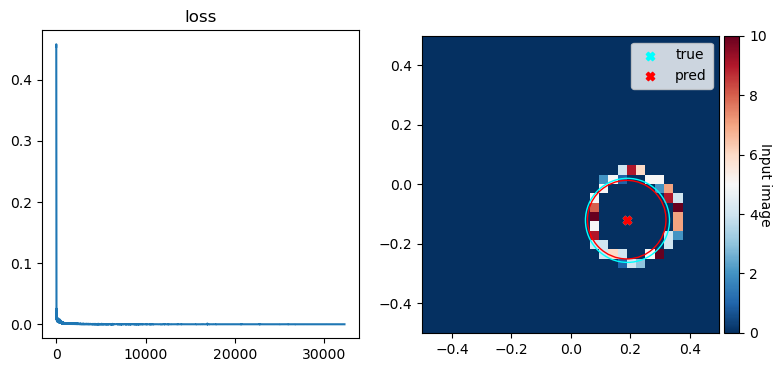

iter 32500 , loss 2.1539785e-05 , lr 0.0003
Circle at (-0.35,0.41) with variance 0.022
Circle at (-0.35,0.40) with variance 0.021


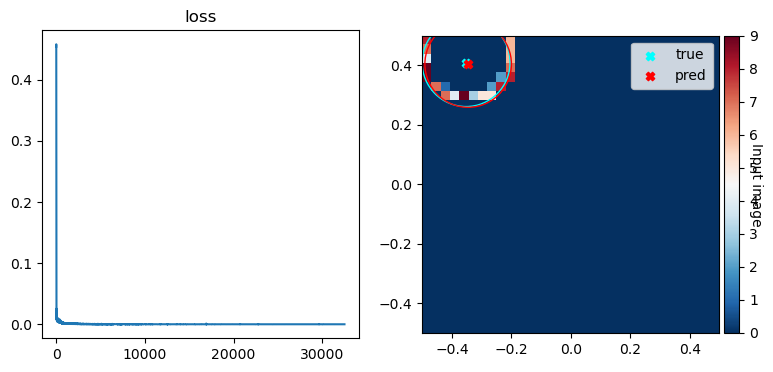

iter 32750 , loss 1.3588642e-05 , lr 0.0003
Circle at (-0.16,-0.08) with variance 0.012
Circle at (-0.15,-0.09) with variance 0.012


iter 33000 , loss 2.6417445e-05 , lr 0.0003
Circle at (-0.28,0.01) with variance 0.033
Circle at (-0.28,0.01) with variance 0.035


iter 33250 , loss 2.3412771e-05 , lr 0.0003
Circle at (-0.12,-0.23) with variance 0.029
Circle at (-0.12,-0.23) with variance 0.029


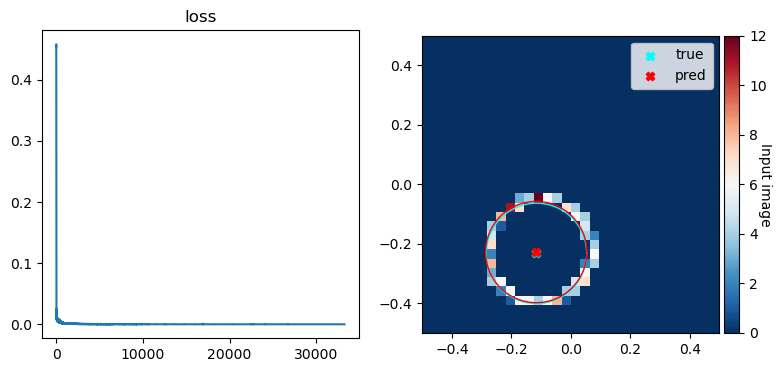

iter 33500 , loss 1.9474588e-05 , lr 0.0003
Circle at (-0.48,0.13) with variance 0.035
Circle at (-0.48,0.13) with variance 0.035


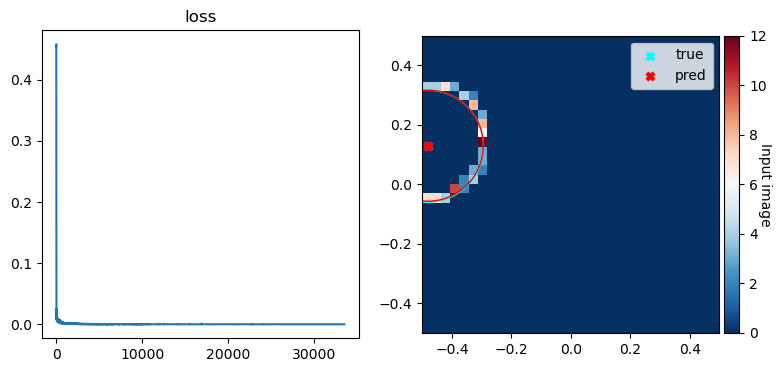

iter 33750 , loss 3.5088946e-05 , lr 0.0003
Circle at (0.32,0.28) with variance 0.027
Circle at (0.32,0.28) with variance 0.027


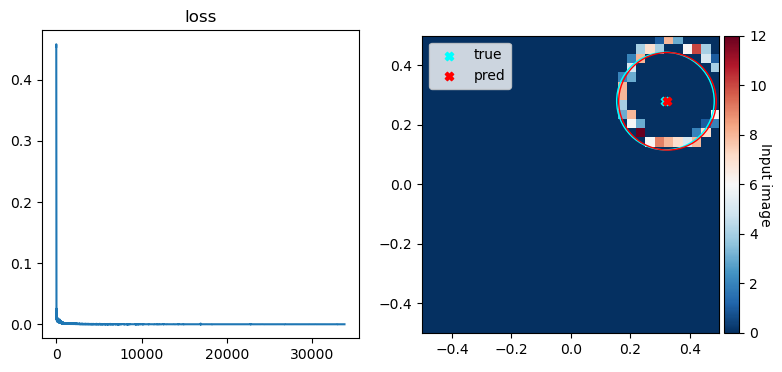

iter 34000 , loss 2.740033e-05 , lr 0.0003
Circle at (0.26,0.35) with variance 0.041
Circle at (0.26,0.36) with variance 0.044


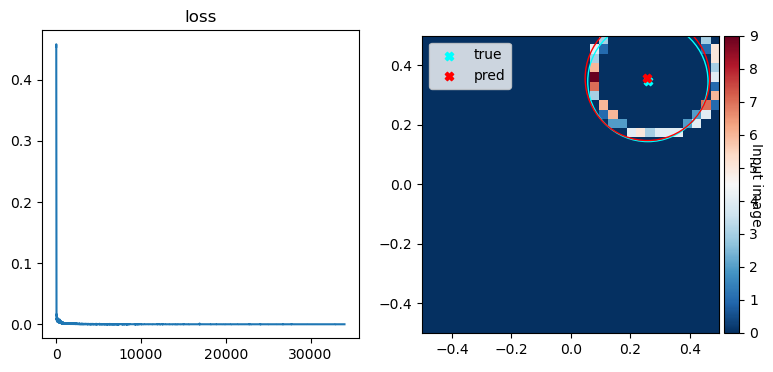

iter 34250 , loss 3.315538e-05 , lr 0.0003
Circle at (0.41,-0.29) with variance 0.028
Circle at (0.42,-0.30) with variance 0.029


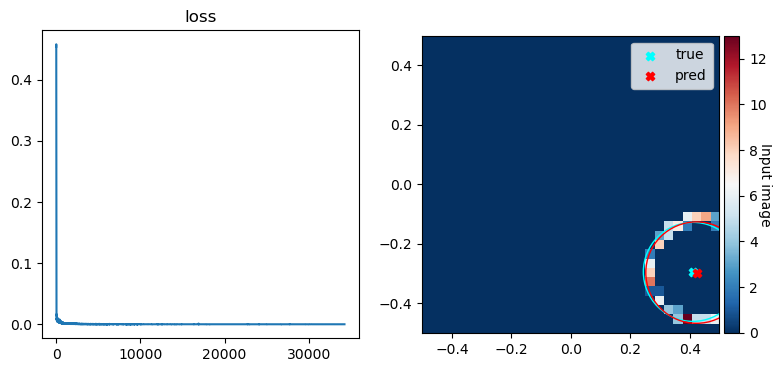

iter 34500 , loss 1.2911397e-05 , lr 0.0003
Circle at (-0.29,-0.12) with variance 0.019
Circle at (-0.30,-0.12) with variance 0.019


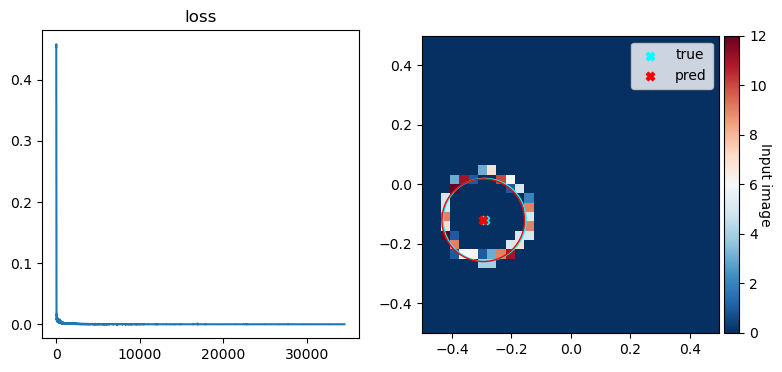

iter 34750 , loss 2.252258e-05 , lr 0.0003
Circle at (-0.34,0.17) with variance 0.014
Circle at (-0.33,0.16) with variance 0.017


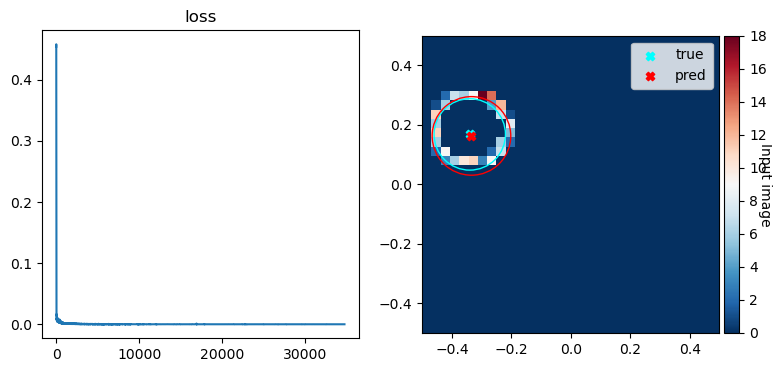

iter 35000 , loss 2.2365111e-05 , lr 0.0003
Circle at (0.28,0.44) with variance 0.049
Circle at (0.28,0.42) with variance 0.042


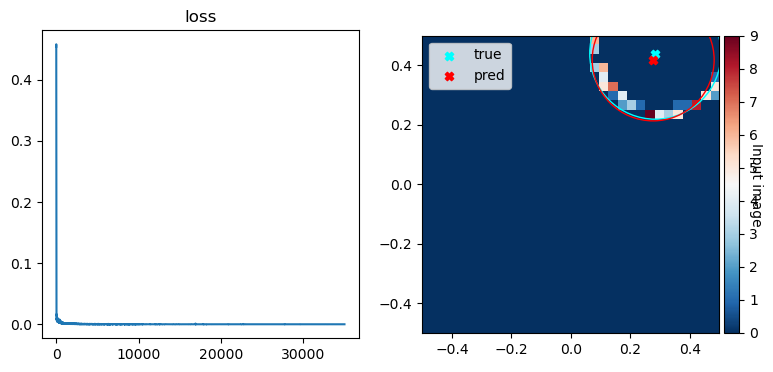

iter 35250 , loss 2.1325548e-05 , lr 0.0003
Circle at (-0.19,-0.42) with variance 0.028
Circle at (-0.19,-0.43) with variance 0.033


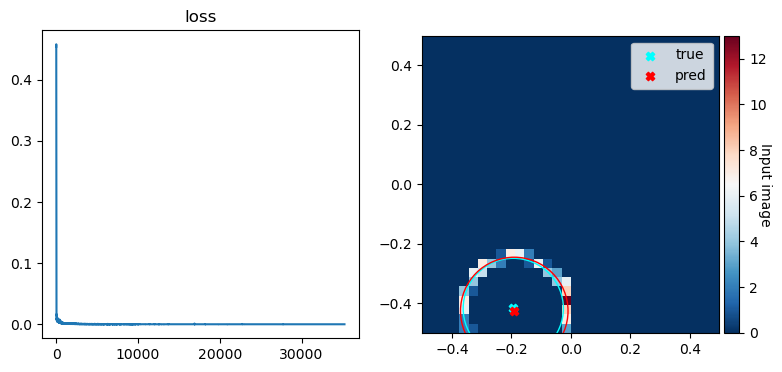

iter 35500 , loss 1.9831255e-05 , lr 0.0003
Circle at (-0.27,-0.34) with variance 0.032
Circle at (-0.27,-0.34) with variance 0.030


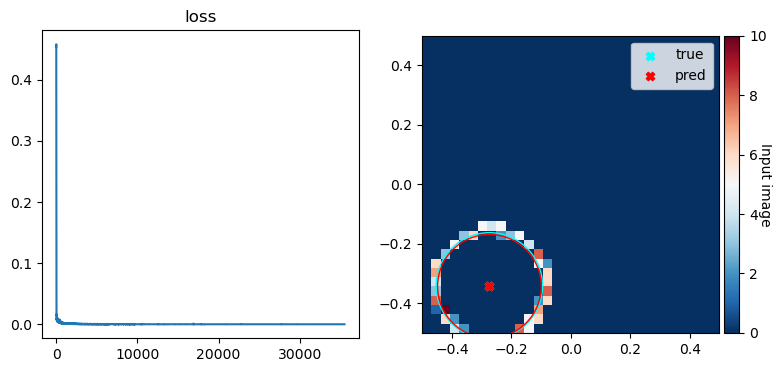

iter 35750 , loss 1.7271901e-05 , lr 0.0003
Circle at (-0.23,-0.31) with variance 0.019
Circle at (-0.23,-0.31) with variance 0.015


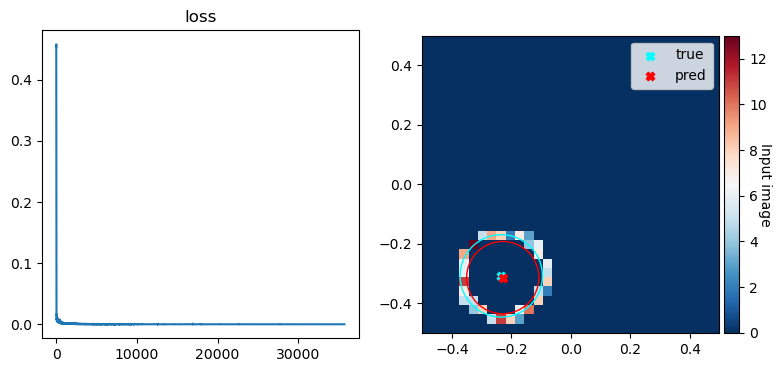

iter 36000 , loss 2.5623747e-05 , lr 0.0003
Circle at (-0.48,0.22) with variance 0.027
Circle at (-0.48,0.22) with variance 0.026


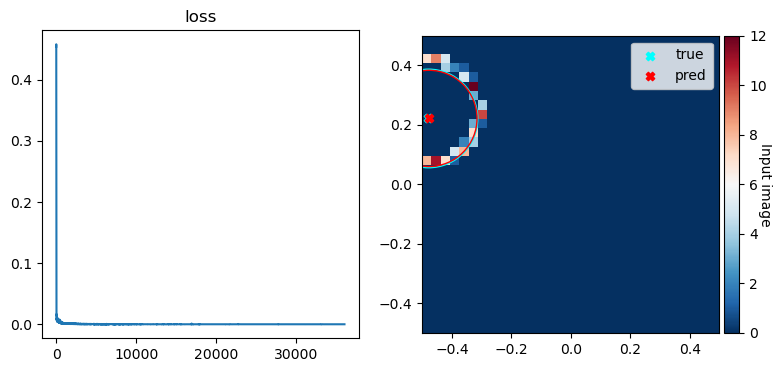

iter 36250 , loss 2.4027217e-05 , lr 0.0003
Circle at (-0.48,-0.04) with variance 0.033
Circle at (-0.49,-0.04) with variance 0.033


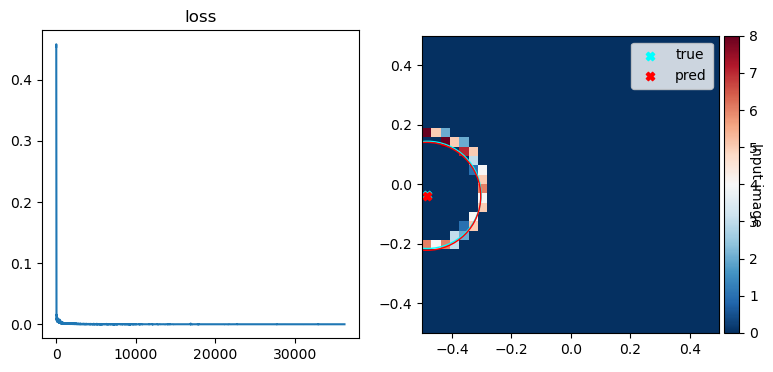

iter 36500 , loss 2.3362785e-05 , lr 0.0003
Circle at (0.04,-0.07) with variance 0.040
Circle at (0.04,-0.07) with variance 0.040


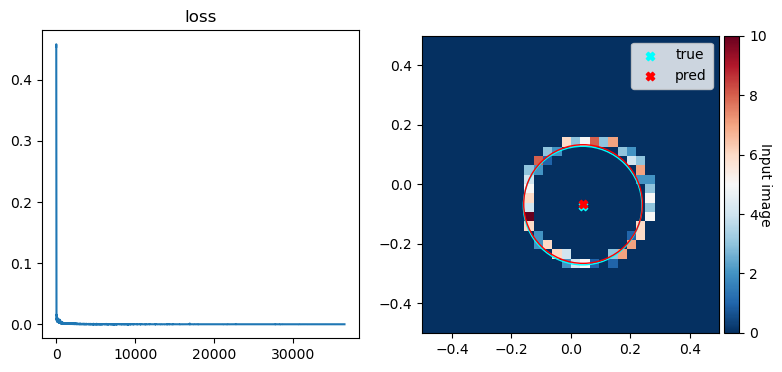

iter 36750 , loss 4.9928552e-05 , lr 0.0003
Circle at (0.10,0.47) with variance 0.012
Circle at (0.11,0.46) with variance 0.015


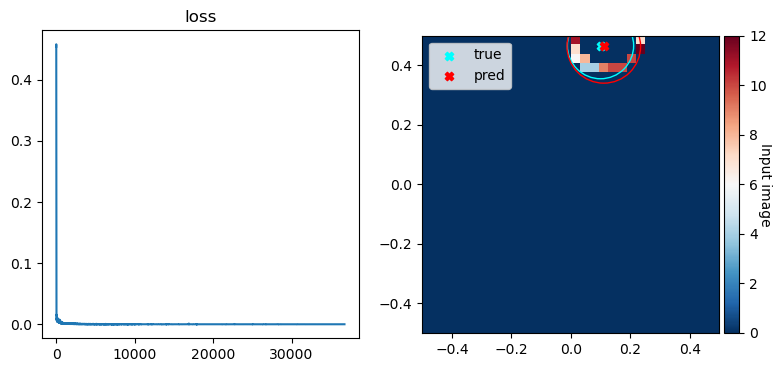

iter 37000 , loss 1.778314e-05 , lr 0.0003
Circle at (-0.20,0.34) with variance 0.038
Circle at (-0.21,0.34) with variance 0.038


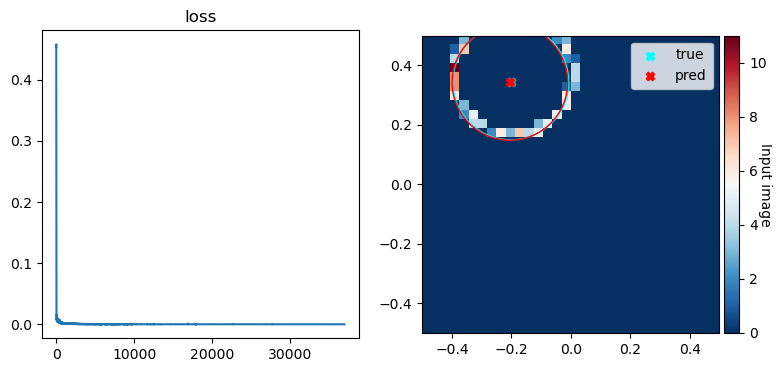

iter 37250 , loss 1.49272655e-05 , lr 0.0003
Circle at (-0.12,-0.34) with variance 0.045
Circle at (-0.11,-0.34) with variance 0.044


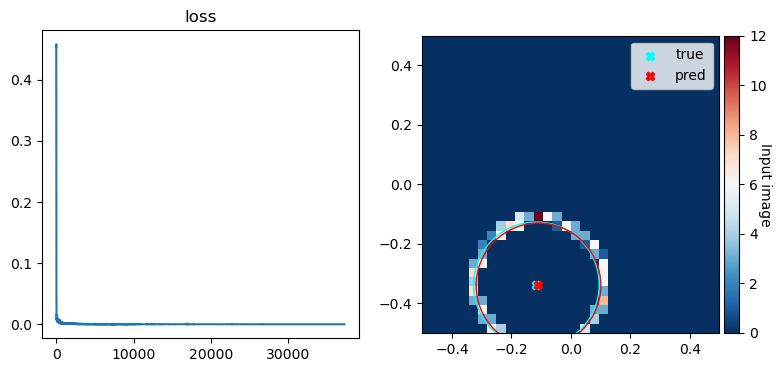

iter 37500 , loss 2.6879161e-05 , lr 0.0003
Circle at (-0.07,-0.12) with variance 0.036
Circle at (-0.07,-0.12) with variance 0.035


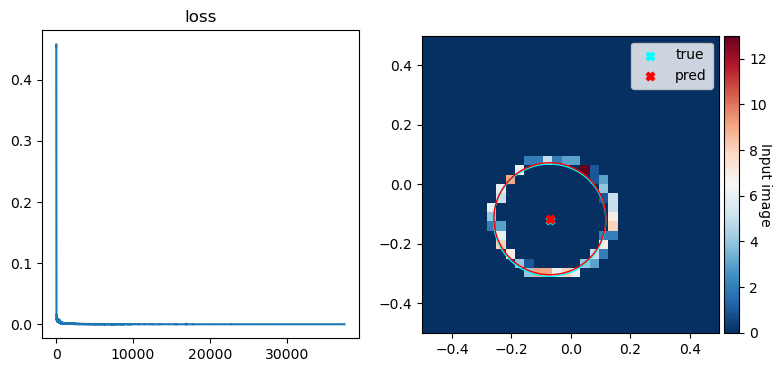

iter 37750 , loss 2.8902941e-05 , lr 0.0003
Circle at (-0.48,0.23) with variance 0.023
Circle at (-0.47,0.22) with variance 0.021


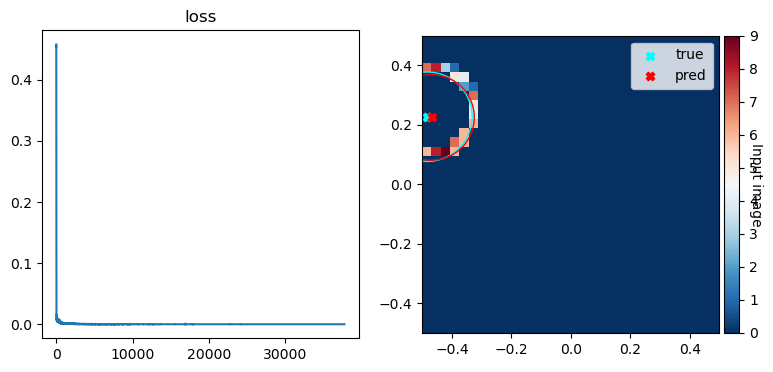

iter 38000 , loss 2.0693971e-05 , lr 0.0003
Circle at (0.38,0.01) with variance 0.033
Circle at (0.39,0.01) with variance 0.035


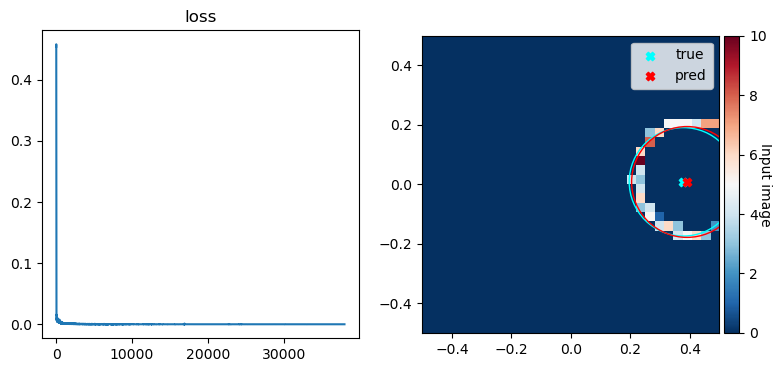

iter 38250 , loss 2.7609514e-05 , lr 0.0003
Circle at (0.29,-0.20) with variance 0.037
Circle at (0.30,-0.20) with variance 0.038


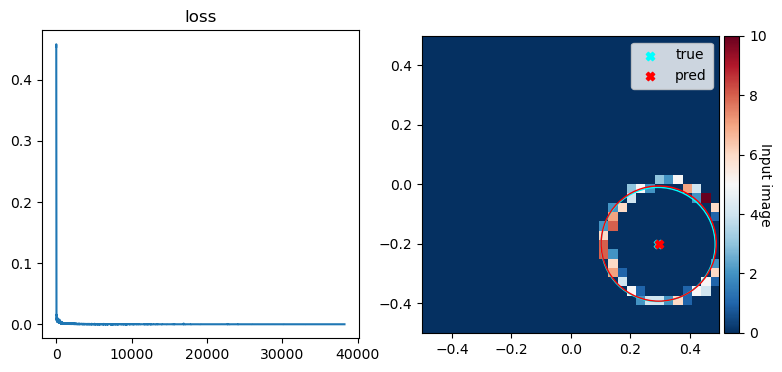

iter 38500 , loss 3.2970955e-05 , lr 0.0003
Circle at (-0.27,0.01) with variance 0.028
Circle at (-0.27,0.01) with variance 0.027


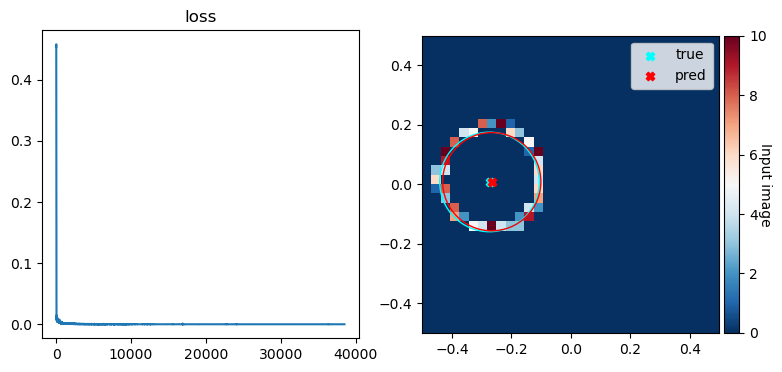

iter 38750 , loss 2.1130543e-05 , lr 0.0003
Circle at (0.24,-0.06) with variance 0.019
Circle at (0.23,-0.06) with variance 0.016


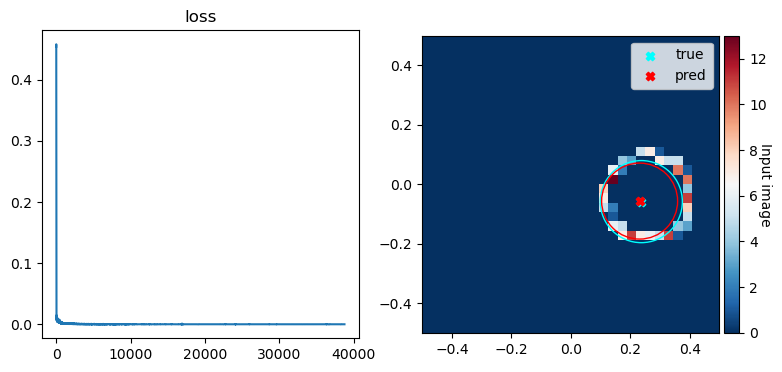

iter 39000 , loss 2.5678562e-05 , lr 0.0003
Circle at (-0.03,-0.29) with variance 0.030
Circle at (-0.03,-0.28) with variance 0.029


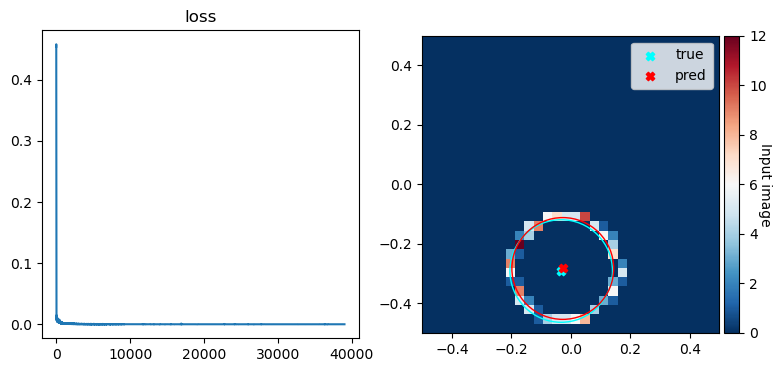

iter 39250 , loss 2.0119192e-05 , lr 0.0003
Circle at (-0.42,0.42) with variance 0.048
Circle at (-0.41,0.41) with variance 0.044


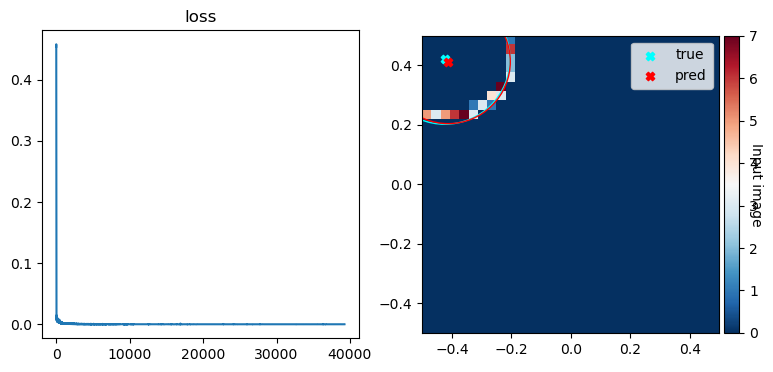

iter 39500 , loss 1.4511988e-05 , lr 0.0003
Circle at (0.43,0.18) with variance 0.016
Circle at (0.43,0.18) with variance 0.018


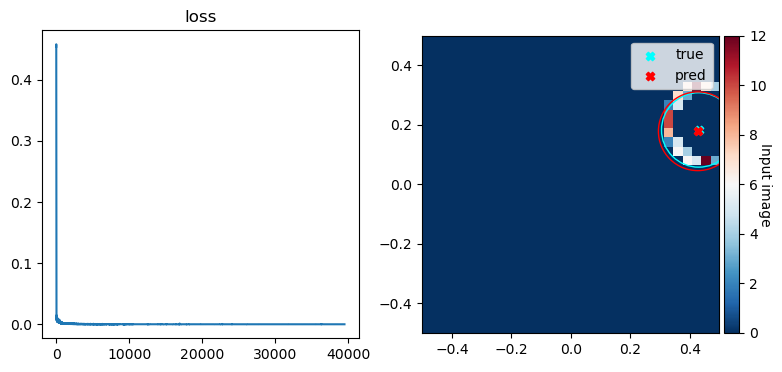

iter 39750 , loss 1.8159382e-05 , lr 0.0003
Circle at (-0.22,-0.33) with variance 0.026
Circle at (-0.22,-0.33) with variance 0.024


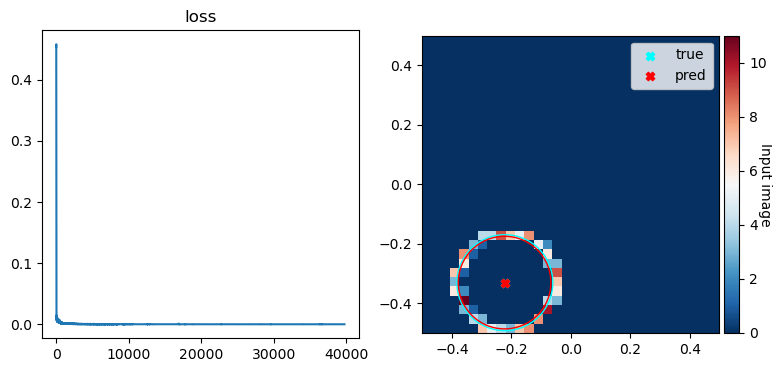

In [27]:
regCNN = regressionCNN().to(device)

regCNN,losses = train_reg(regCNN,40_000)

In [28]:
bs

64

**Qs:** 
1. What does it mean when the loss is so noisy?
2. Could I break apart the position and radius terms in the loss?
3. Could I _quantify_ performance vs. radius and position?
4. Would ensembing help the cases where one model gets the wrong pos, radius?

(0.0, 0.002)

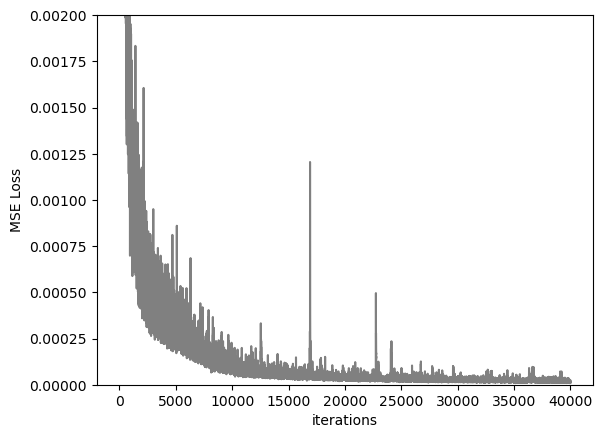

In [29]:
plt.plot(losses,color='grey')
plt.xlabel('iterations')
plt.ylabel('MSE Loss')
plt.ylim(0,.002)

^ would a bigger batch size be helpful?

In [30]:
N_te = int(1e4) # 10k

with torch.no_grad():
    X_te, Y_te, mask_te = make_batch(N_te)
    pred_te = regCNN(X_te)


In [31]:
MSE = (pred_te-Y_te)**2

torch.mean(MSE,axis=0)

tensor([2.4756e-05, 2.5020e-05, 4.7178e-06], device='mps:0')

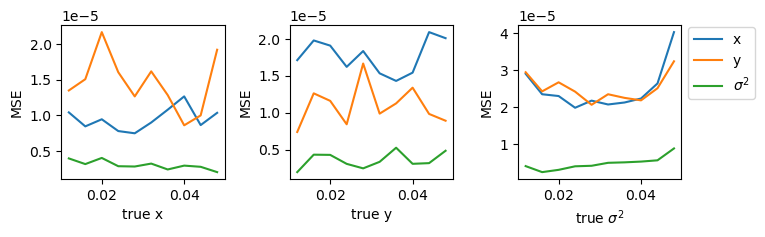

In [32]:
fig, axs = plt.subplots(1,3,figsize=(8,2),gridspec_kw={'wspace':.4})

nbins=10
bin_edg = [np.linspace(stdlow,stdhigh,nbins+1)]*2+[np.linspace(stdlow,stdhigh,nbins+1)]
var_labels = ['x','y','$\sigma^2$']

for i, ax, bins,tv in zip(range(3), axs, bin_edg,var_labels):
    
    xx = 0.5 * (bins[1:] + bins[:-1])
    
    for j,rv in zip(range(3), var_labels):
        
        num = np.histogram(Y_te[:,i].cpu().numpy(),bins,weights=MSE[:,j].cpu().numpy())[0]
        den = np.histogram(Y_te[:,i].cpu().numpy(),bins)[0]
        
        err_j = num / den
        
        # Show the error in reco var j w/r.t. truth variable i
        ax.plot(xx,err_j,label=rv,color=f'C{j}')
        
    ax.set_xlabel(f'true {tv}')
    ax.set_ylabel(f'MSE')
    
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
ax.legend(bbox_to_anchor=(1,1.03))
        
plt.show()

**Note:** The (x,y) positions 

### Bonus: Set prediction

Hmmmm.... but actually, if I have a mask that predicts the feature maps... maybe this is good enough?

I.e, I could do the set prediction task on the rings, except... precict the occupancy map for each ring(?)